# Exam 3 Code - Tuo Li #
**Note:** This document contains the complete code for the project. However, due to its length and the inclusion of several paid API calls, multiple checkpoint files were generated throughout the process.

To fully re-run the code, please follow the instructions provided and import the necessary checkpoint files when needed. Thank you!

# Summary #

This project serves as my answer to Exam 3, with the objective of developing a machine learning model to predict positive market movements (uptrends).

The selected asset is QQQ, an exchange-traded fund (ETF) that tracks the Nasdaq 100 Index. The prediction focuses on daily returns using a binomial classification approach, leveraging ten years of historical market data, with the dependent variable labeled as $[0, 1]$.

Throughout the model development process, I will address all exam questions while covering key steps, including data preparation, entropy analysis, feature selection, model building, tuning, and evaluation. Finally, I will implement the selected model to conduct backtesting, assessing its real-world performance.

<a id='content'></a>
# Content # 
#### [Preparation](#P)
- [P1. Import Relevant Libraries](#P1)
- [P2. Obtain and Process Trading Data](#P2)  
   - [P2.1 Obtain Trading Data](#P21)
   - [P2.2 Decide Target](#P22)
#### [A. Explanation of Entropy in Classification](#A)
#### [B. Feature Selection Using the Funnelling Approach](#B)
- [B1. Create Features](#B)
   - [B1.1 Create Features from Trading Data](#B11)
   - [B1.2 Create Macro Economy Features](#B12)
   - [B1.3 Create Features from Daily News](#B13)
      - [B1.3.1 Include the News Titles](#B131)
      - [B1.3.2 Use AI for Sentiment Analysis and Generate Relevant Features](#B132)
      - [B1.3.3 Make Decisions on 'Market_Event' and Add Sentiment Polarity for the News Titles](#B133)
- [B2. Select Features](#B2)
   - [B2.1 Filter](#B21)
      - [B2.1.1 Variable Inflation Factors (VIF)](#B211)
      - [B2.1.2 SelectKBest](#B212)
   - [B2.2 Wrapper](#B22)
      - [B2.2.1 Recursive Feature Elimination (RFE)](#B221)
      - [B2.2.2 Recursive Feature Elimination with Cross-Validation (RFECV)](#B222)
   - [B2.3 Emebeded Methods](#B23)
#### [C. Model Building, Tuning and Evaluation](#C)
- [C1. XGBoost](#C1)
   - [C1.1 Build A Model (XGBoost)](#C11)
   - [C1.2 Tune the Hyperparameters (XGBoost)](#C12)
   - [C1.3 Evaluate the Optimized Model's Prediction Quality (XGBoost)](#C13)
- [C2. AdaBoost](#C2)
   - [C2.1 Build A Model (AdaBoost)](#C21)
   - [C2.2 Tune the Hyperparameters (AdaBoost)](#C22)
   - [C2.3 Evaluate the Optimized Model's Prediction Quality (AdaBoost)](#C23)
- [C3. LightGBM](#C3)
   - [C3.1 Build A Model (LightGBM)](#C31)
   - [C3.2 Tune the Hyperparameters (LightGBM)](#C32)
   - [C3.3 Evaluate the Optimized Model's Prediction Quality (LightGBM)](#C33)
- [C4. Conclusion of Models](#C4)
#### [Trading Strategy Practice with Backtesting](#T)
- [T1. Profit Analysis](#T1)
- [T2. Pyfolio Analysis](#T2)


<a id='P'></a>
 # Preparation # 

<a id='P1'></a>
## P1. Import relevant libraries ##

In [1]:
# Basic Functional Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import re
from datetime import datetime, timedelta

# Market Data & News Aggregation
import yfinance as yf
from gnews import GNews

# Preprocessing & Cross-Validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Classifiers & ML Models
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import shap

#Quant Finance
from quantmod.indicators import *

# AI Models & LLM Integration
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Model Evaluation Metrics
from sklearn.metrics import (accuracy_score, auc, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay,
confusion_matrix, classification_report)
import pyfolio as pf

<a id='P2'></a>
## P2. Obtain and Process Trading Data ##

<a id='P21'></a>
### P2.1 Obtain Trading Data ###

Obtain the 10 year QQQ price data from 2015 all the way till right before the exam, 15 May 2025.  

The data was extracted from Yahoo finance with Python, and I saved it with a csv copy for convenience.

In [2]:
# #Code of obtaining trading data from Yahoo Finance.
# ticker = "QQQ"
# start_date = "2015-01-01"
# end_date = "2025-05-14"

# # Download historical data
# qqq_data = yf.download(ticker, start=start_date, end=end_date)

# # Save to csv
# qqq_data.to_csv('QQQ_2015-2025.csv)

In [2]:
df_qqq = pd.read_csv('./data/QQQ_2015-2025.csv', skiprows=[1,2]).rename(columns = {'Price':'Date'})
df_qqq['Date'] = pd.to_datetime(df_qqq['Date']).dt.date
df_qqq = df_qqq.set_index('Date')

Check the data.

In [3]:
df_qqq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2608 entries, 2015-01-02 to 2025-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2608 non-null   float64
 1   Close      2608 non-null   float64
 2   High       2608 non-null   float64
 3   Low        2608 non-null   float64
 4   Open       2608 non-null   float64
 5   Volume     2608 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 142.6+ KB


In [4]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,95.123268,102.940002,104.199997,102.440002,103.760002,31314600
2015-01-05,93.727943,101.430000,102.610001,101.139999,102.489998,36521300
2015-01-06,92.471214,100.070000,101.750000,99.620003,101.580002,66205500
2015-01-07,93.663261,101.360001,101.599998,100.489998,100.730003,37577400
2015-01-08,95.455971,103.300003,103.500000,102.110001,102.220001,40212600


Check missing values and basic descriptive parameter.

In [5]:
df_qqq.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [6]:
df_qqq.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,2608.0,2.466861e+02,1.255730e+02,8.990712e+01,1.358262e+02,2.090587e+02,3.458056e+02,5.387167e+02
Close,2608.0,2.529182e+02,1.241010e+02,9.632000e+01,1.434275e+02,2.155600e+02,3.521625e+02,5.395200e+02
High,2608.0,2.547431e+02,1.250471e+02,9.705000e+01,1.438825e+02,2.169950e+02,3.551925e+02,5.408100e+02
Low,2608.0,2.508164e+02,1.230275e+02,8.474000e+01,1.426650e+02,2.136300e+02,3.493150e+02,5.364600e+02
Open,2608.0,2.528630e+02,1.241019e+02,9.423000e+01,1.435100e+02,2.159050e+02,3.527825e+02,5.397300e+02
Volume,2608.0,4.146381e+07,2.206421e+07,7.079300e+06,2.562858e+07,3.633190e+07,5.163375e+07,1.986858e+08


[**Back to Content**](#content)

<a id='P22'></a>
### P2.2 Decide Target ###

Since the project is about predicting the trend for daily returns in binomial classification $[0, 1]$, I will develop this column first, and call it `Target`.    

Let's observe the data before deciding the classification threshold to for the target. I will use `Adj Close` to represent the day's price as it counts more process factors (e.g. corporate action, splits , dividends) to the share price.  

QQQ price trend 2015-2025 with `Adj Close`:

Text(0, 0.5, 'Adj Close Price ($)')

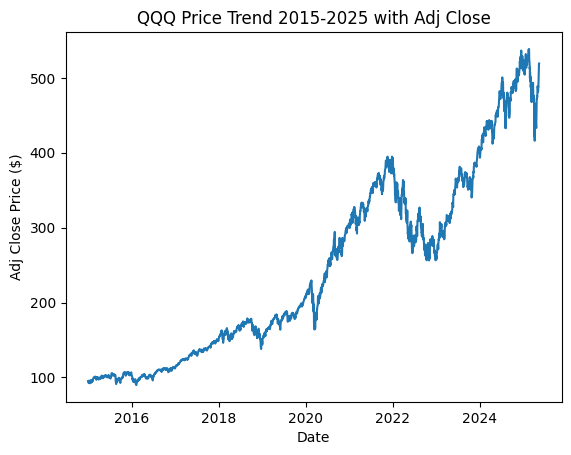

In [14]:
plt.plot(df_qqq['Adj Close'])
plt.title("QQQ Price Trend 2015-2025 with Adj Close") 
plt.xlabel("Date")
plt.ylabel("Adj Close Price ($)")

Then, create the column of `Daily Return` and observe the distribution.

In [8]:
df_qqq['Daily_Return'] = df_qqq['Adj Close'].pct_change(1) 

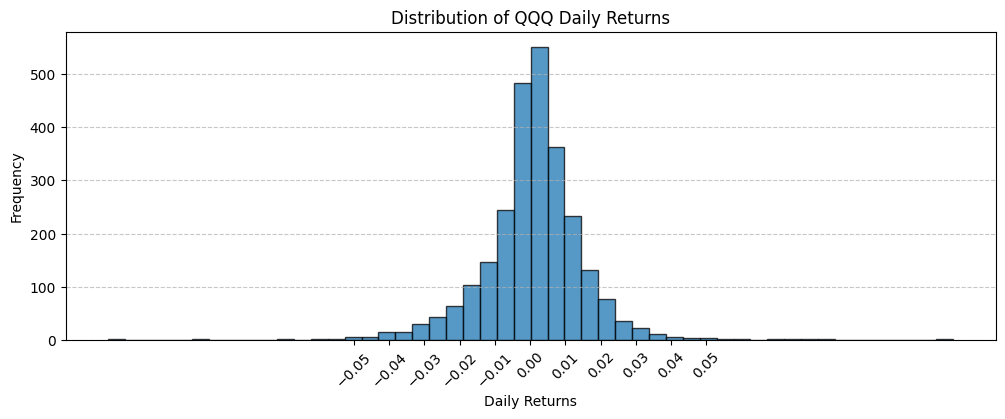

In [9]:
# Plot histogram of daily returns
plt.figure(figsize=(12, 4))
plt.hist(df_qqq['Daily_Return'], bins=50, edgecolor='black', alpha=0.75)

# Customize x-axis tick values
x_ticks = np.arange(-0.05, 0.06, 0.01)  # Adjust range as needed
plt.xticks(x_ticks, rotation=45)  # Rotates labels by 45 degrees

# Labels & Grid
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.title("Distribution of QQQ Daily Returns")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

As illustrated in the histogram, QQQ's daily returns follow a roughly normal distribution, with a slight positive skew in the mean.

To optimize classification performance, I will set the threshold at $-1\%$ for following reasons:
- An uneven class split helps maintain model robustness while mitigating overfitting.
- A key objective is to generate meaningful predictions for positive market moves (class 1), and a broader class distribution enhances precision in identifying the positive movement.

Under this target definition, returns below $-1\%$ are labeled as 0. A target value of 1 is assigned if the next day's closing price is at least $99\%$ of the current day's closing price, indicating a buying opportunity; otherwise, no action is taken.

Set up threshold and create the column of `Target` and check the splits.

In [10]:
threshold = - 0.01
df_qqq['Target'] = (df_qqq['Daily_Return'].shift(-1) > threshold).astype(int)
df_qqq['Target'].value_counts()

Target
1    2191
0     417
Name: count, dtype: int64

Within this column, 2191 instances fall under Class 1, while 417 belong to Class 0, resulting in an approximate 5:1 class distribution, which is within an acceptable range.

Check the data now.

In [11]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target
Date,,,,,,,,
2015-01-02,95.123268,102.940002,104.199997,102.440002,103.760002,31314600,NaN,0
2015-01-05,93.727943,101.430000,102.610001,101.139999,102.489998,36521300,-0.014669,0
2015-01-06,92.471214,100.070000,101.750000,99.620003,101.580002,66205500,-0.013408,1
2015-01-07,93.663261,101.360001,101.599998,100.489998,100.730003,37577400,0.012891,1
2015-01-08,95.455971,103.300003,103.500000,102.110001,102.220001,40212600,0.019140,1


In [12]:
df_qqq.tail()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target
Date,,,,,,,,
2025-05-09,487.970001,487.970001,491.540009,486.200012,490.209991,27767400,-0.000655,1
2025-05-12,507.850006,507.850006,507.890015,501.480011,506.989990,45090600,0.040740,1
2025-05-13,515.590027,515.590027,517.390015,508.420013,509.160004,53269600,0.015241,1
2025-05-14,518.679993,518.679993,519.229980,515.750000,516.770020,47014500,0.005993,1
2025-05-15,519.250000,519.250000,521.929993,515.169983,516.520020,50153300,0.001099,0


The prepration is done, let's visit the questions.

[**Back to Content**](#content)

<a id='A'></a>
# A. Explanation of Entropy in Classification #
What does entropy reveal about the quality of the partitions in a classification problem?  

Answer below with True / False and explain the reasoning behind your choice.  
(a) High entropy means the partitions are pure.  
(b) High entropy means the partitions are impure.

## Answer: ##

Entropy quantifies the impurity or uncertainty within a partition.  

High entropy implies that the classes in a partition are mixed (e.g., 50% Class A and 50% Class B). This means the partition is impure, as there is no clear dominance of a single class. Low entropy (near 0) indicates a pure partition where one class dominates (e.g., 100% Class A).  

**Therefore, Statement (a) is False, and Statement (b) is True.**  

This is also reflected with the formula of entropy:
$$ -\sum_{k=1}^{K} p_klog_2(p_k)$$
where $K$ is total amount of classes and $p_k$ is the probability of class $k$.
$$\because 0\leq{p_k}\leq1$$ $$\therefore -1\leq{p_klog_2(p_k)}\leq0$$

And as shown above, the value of $p_{k}log_2(p_{k})$ approaches $0$ as $p_k$ nears either $0$ or $1$. This negative term becomes most significant when $p_k$ is close to the middle point: $0.5$, where uncertainty is highest. Consequently, entropy, computed as the sum of these negative values, multiplied by $-1$, results in a larger positive value, reflecting greater disorder in the system.  

In our case, $k=2$, and the entropy formula will be:
$$ -p_klog_2(p_k)-(1-p_k)log_2(1-p_k)$$
As discussed, the entropy values will be $0$ when $p_k = 0\ or\  1$, and it will reach to its maximum $1$ when $p_k = 0.5$. The visualization is below:

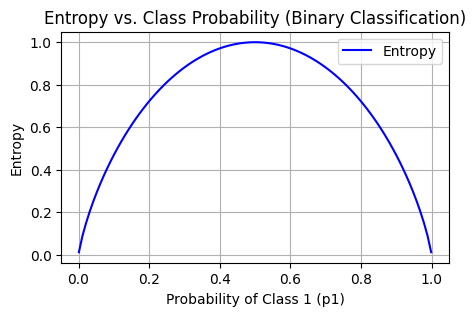

In [16]:
# Probability range from 0 to 1
p1 = np.linspace(0.001, 0.999, 100)  # Avoid log(0) issues

#define a calculation function of entropy
def calculate_entropy(p) -> float:
    return -(p*np.log2(p)+(1-p)*np.log2(1-p))

# Compute entropy
entropy = calculate_entropy(p1)

# Plot entropy
plt.figure(figsize=(5, 3))
plt.plot(p1, entropy, label='Entropy', color='blue')
plt.xlabel('Probability of Class 1 (p1)')
plt.ylabel('Entropy')
plt.title('Entropy vs. Class Probability (Binary Classification)')
plt.legend()
plt.grid()
plt.show()

Then, let's calculate the entropy of 'Target' in our case.

In [17]:
p_qqq = df_qqq['Target'].sum()/len(df_qqq['Target'])
entropy_qqq = calculate_entropy(p_qqq)
print(f'The probability of QQQ ETF from 2015-2025 to reach Class 1 is {p_qqq:.2%}. \nThe entropy is {entropy_qqq:.3}.')

The probability of QQQ ETF from 2015-2025 to reach Class 1 is 84.01%. 
The entropy is 0.634.


[**Back to Content**](#content)

<a id = "B"></a>
# B. Feature Selection Using the Funnelling Approach #
Perform feature selection for a machine learning model using a multi-step process by combining techniques from fillter, wrapper, and embedded methods.  
(a) Explain the feature selection process using the three categories of feature selection methods, step
by step.  
(b) Justify the selection of features retained at each step.  
(c) Provide the final list of selected features.

## Answer: ##

<a id = "B1"></a>
## B1. Create Features ##

<a id = "B11"></a>
### B1.1 Create Features from Trading Data ###

At the first step of creating features, we will follow some common practices and include following candidtates:  

**SMA (Simple Moving Average):** $$ SMA = \frac{1}{N}\sum_{i=1}^{N} P_i$$
where $P_i$ is the praice at period $i$, and $N$ is the number of days in our case. 

**EMA (Exponential Moving Average):** $$ EMA_t = \alpha P_t + (1-\alpha)EMA_{t-1} $$
where $\alpha$ is the smoothing factor, typically calculated as $\frac{2}{N+1}$. EMA gives more weight to recent prices and eacts faster to price changes than SMA, making it useful for short-term trading signals.  

We will select features of SMA EMA with $N$ range from 5 days to 50 days at the step of 5 days.  

**ATR (Average True Range):** $$ATR = \frac{1}{N}\sum_{i=1}^{N} TR_i$$
where $TR_i$ means 'True Range' and is the greatest of the gaps between Current High and Current Low, Current High and Previous Close, or Current Low and Previous Close. In quantmod, $N$ by default is 14 days. ATR is common way to measures volatility.

**Bollinger Bands (BBANDS_L, BBANDS_U):** $$BBANDS_U = SMA + 2\sigma$$ $$BBANDS_L = SMA - 2\sigma$$
where $\sigma$ is the standard deviation. These 2 bands represents the range of 95% price movement in the past $N$ days. In quantmod, $N$ here by default is 5 days.   

**RSI (Relative Strength Index):** $$RSI = 100 - \frac{100}{1+RS}$$
$$RS = \frac{Average\ Gain\ over\ N\ periods}{Average\ Loss\ over\ N\ periods}$$
Here, we will set $N$ to be 14 days. RSI measures momentum by comparing recent gains and losses.  

**MACD (Moving Average Convergence Divergence):** $$MACD = EMA_{12} - EMA_{26}$$
Here, we will set $N$ to be 5 days. MACD tracks trend strength and reversals using two moving averages.

**The price difference between high and low, open and close in one day** $$H-L = High - Low$$ $$O-C = Open - Close$$ 
These are simple features to show the variance within the day.

In [18]:
# use quantmod to use indicators
features_list = []
for r in range(5, 50, 5):
    df_qqq['SMA_'+str(r)] = SMA(df_qqq['Adj Close'], r)
    df_qqq['EMA_'+str(r)] = EMA(df_qqq['Adj Close'], r)
    features_list.append('SMA_'+str(r))
    features_list.append('EMA_'+str(r))

df_qqq['ATR'] = ATR(df_qqq)
df_qqq['BBANDS_L'] = BBands(df_qqq['Adj Close'],5,2)[0]
df_qqq['BBANDS_M'] = BBands(df_qqq['Adj Close'],5,2)[1]
df_qqq['BBANDS_U'] = BBands(df_qqq['Adj Close'],5,2)[2]
df_qqq['RSI'] = RSI(df_qqq['Adj Close'], 14)
df_qqq['MACD'] = MACD(df_qqq['Adj Close'], 5, 12, 26)[0]

df_qqq['H-L'] = df_qqq['High'] - df_qqq['Low']
df_qqq['O-C'] = df_qqq['Open'] - df_qqq['Close']

# Drop NaN values
df_qqq.dropna(inplace=True)

In [19]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target,SMA_5,EMA_5,...,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD,H-L,O-C
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-09,99.540298,107.720001,107.989998,107.190002,107.629997,26237100,0.002886,0,100.000490,99.860236,...,96.530326,97.538254,0.865715,98.847136,100.000490,101.153843,55.436268,1.128680,0.799995,-0.090004
2015-03-10,97.692177,105.720001,106.980003,105.720001,106.949997,34234500,-0.018567,1,99.418332,99.137550,...,96.587413,97.544946,0.974286,97.273334,99.418332,101.563330,41.408097,0.882574,1.260002,1.229996
2015-03-11,97.128510,105.110001,106.010002,105.070000,105.879997,25459700,-0.005770,1,98.801060,98.467870,...,96.662981,97.526840,0.991429,96.098337,98.801060,101.503784,34.751595,0.634734,0.940002,0.769997
2015-03-12,97.766098,105.800003,105.919998,104.959999,105.029999,21473200,0.006564,1,98.276190,98.233946,...,96.780645,97.537242,0.975000,96.161418,98.276190,100.390962,34.519365,0.484185,0.959999,-0.770004
2015-03-13,97.341042,105.339996,106.120003,104.680000,105.699997,42021100,-0.004348,1,97.893625,97.936311,...,96.862373,97.528712,1.046429,95.980740,97.893625,99.806510,31.890688,0.326809,1.440002,0.360001


In [20]:
df_qqq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2564 entries, 2015-03-09 to 2025-05-15
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Adj Close     2564 non-null   float64
 1   Close         2564 non-null   float64
 2   High          2564 non-null   float64
 3   Low           2564 non-null   float64
 4   Open          2564 non-null   float64
 5   Volume        2564 non-null   int64  
 6   Daily_Return  2564 non-null   float64
 7   Target        2564 non-null   int64  
 8   SMA_5         2564 non-null   float64
 9   EMA_5         2564 non-null   float64
 10  SMA_10        2564 non-null   float64
 11  EMA_10        2564 non-null   float64
 12  SMA_15        2564 non-null   float64
 13  EMA_15        2564 non-null   float64
 14  SMA_20        2564 non-null   float64
 15  EMA_20        2564 non-null   float64
 16  SMA_25        2564 non-null   float64
 17  EMA_25        2564 non-null   float64
 18  SMA_30        2564

[**Back to Content**](#content)

<a id = "B12"></a>
### B1.2 Create Macro Economy Features ###

Next, I believe the Federal Funds Effective Rate likely influences QQQ ETF movements, as the technology sector is highly sensitive to borrowing costs and liquidity, both of which are directly affected by rate fluctuations.  

I have sourced monthly data from the Federal Reserve Bank of St. Louis and will incorporate it into the data for analysis.

In [21]:
df_fedrate = pd.read_csv('./data/FEDFUNDS.csv')

At the time of downloading this file, the monthly rate for May 2025 was unavailable. After verifying online, I found it to be 4.33, and I will manually add it to the dataset.

In [22]:
new_row = {"observation_date": "2025-05-01", "FEDFUNDS": 4.33}
df_fedrate.loc[len(df_fedrate)] = new_row

In [23]:
df_fedrate.tail()

,observation_date,FEDFUNDS
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33
849,2025-04-01,4.33
850,2025-05-01,4.33


In [24]:
df_fedrate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, 0 to 850
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  851 non-null    object 
 1   FEDFUNDS          851 non-null    float64
dtypes: float64(1), object(1)
memory usage: 19.9+ KB


The Federal Rate data is recorded on a monthly basis, with time information stored in a separate column. To ensure alignment with df_qqq for integration, we will first set the date column as the index.

In [25]:
df_fedrate.set_index("observation_date", inplace=True)
df_fedrate.index = pd.to_datetime(df_fedrate.index).date

In [26]:
df_fedrate.head()

,FEDFUNDS
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


Then we map the monthly Federal Rate to our daily trading data using a forward-filling technique, ensuring that in the merged dataset, each day's federal rate correctly aligns with the corresponding monthly value.

In [27]:
df_qqq["FEDFUNDS"] = df_qqq.index.map(lambda date: df_fedrate.FEDFUNDS.asof(date))

In [28]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target,SMA_5,EMA_5,...,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD,H-L,O-C,FEDFUNDS
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-09,99.540298,107.720001,107.989998,107.190002,107.629997,26237100,0.002886,0,100.000490,99.860236,...,97.538254,0.865715,98.847136,100.000490,101.153843,55.436268,1.128680,0.799995,-0.090004,0.11
2015-03-10,97.692177,105.720001,106.980003,105.720001,106.949997,34234500,-0.018567,1,99.418332,99.137550,...,97.544946,0.974286,97.273334,99.418332,101.563330,41.408097,0.882574,1.260002,1.229996,0.11
2015-03-11,97.128510,105.110001,106.010002,105.070000,105.879997,25459700,-0.005770,1,98.801060,98.467870,...,97.526840,0.991429,96.098337,98.801060,101.503784,34.751595,0.634734,0.940002,0.769997,0.11
2015-03-12,97.766098,105.800003,105.919998,104.959999,105.029999,21473200,0.006564,1,98.276190,98.233946,...,97.537242,0.975000,96.161418,98.276190,100.390962,34.519365,0.484185,0.959999,-0.770004,0.11
2015-03-13,97.341042,105.339996,106.120003,104.680000,105.699997,42021100,-0.004348,1,97.893625,97.936311,...,97.528712,1.046429,95.980740,97.893625,99.806510,31.890688,0.326809,1.440002,0.360001,0.11


[**Back to Content**](#content)

<a id = "B13"></a>
### B1.3 Create Features from Daily News ###

News serves as a valuable indicator of market sentiment, particularly in the technology sector, where changes occur frequently. Daily headlines provide insight into how investor behavior is influenced by trending topics.

To analyze this impact, I used the GNews Python library to extract news titles from four major financial and technology media sources — Bloomberg, CNBC, MarketWatch, and TechCrunch, spanning 2015 to 2025. This dataset will help explore how news sentiment affects QQQ's price movements.

*Below is the example code that I used to scrape news data from the past 10 years. It is not fully automated, as it relies on a simple for-loop without functions. I chose this approach for two key reasons:
-  GNews limits excessive automated requests, resulting in IP blocks after a certain threshold, which affected my home IP. To mitigate this, I used other networks scraping the monthly data instead of daily to reduce API calls, then saved it as CSV files for easier future access.
-  Certain parameters require manual input to monitor the extraction process. At times, the results do not accurately align with the intended date range.

In [38]:
# for i in [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]:
#     google_news = GNews(language='en', country='US')
#     google_news.start_date = (i, 2, 1)
#     google_news.end_date = (i, 2, 28)
#     loaded_news = google_news.get_news_by_site('bloomberg.com')

#     df = pd.DataFrame({'Title': [item['title'] for item in loaded_news],'Date': [item['published date'] for item in loaded_news]})
#     df.to_csv('./news/bloomberg/df_bloomberg'+str(i)+'02.csv')
#     print('df_bloomberg'+str(i)+'02.csv')

<a id = "B131"></a>
#### B1.3.1 Include the News Titles ####

**Task 1: Import Bloomberg news titles**

In [39]:
bloomberg_list = glob.glob("./news/bloomberg/df_bloomberg*.csv")
bloomberg_dataframes = []

for file in bloomberg_list:
    df = pd.read_csv(file)  # Read each CSV
    df['Title'] = df['Title'].astype(str)  # Ensure 'Title' is a string
    df['Date'] = pd.to_datetime(df['Date'], format='%a, %d %b %Y %H:%M:%S %Z').dt.date  # Convert 'Date' to datetime
    bloomberg_dataframes.append(df)  # Append to list
df_bloomberg = pd.concat(bloomberg_dataframes, ignore_index=True).drop(columns=['Unnamed: 0']).drop_duplicates().reset_index(drop=True)

In [40]:
df_bloomberg.head()

,Title,Date
0,Churchill Capital Corp X - Bloomberg,2025-05-19
1,Walgreens Explores $4 Billion-Plus Sale of Shi...,2024-01-24
2,BYD Shares Fall as Profit Misses Estimates Ami...,2024-01-29
3,Elon Musk Will Attend Auschwitz Event to Discu...,2024-01-18
4,EU Ready to Play Hardball With Hungary Over Bl...,2024-01-22


In [41]:
df_bloomberg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12489 entries, 0 to 12488
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   12489 non-null  object
 1   Date    12489 non-null  object
dtypes: object(2)
memory usage: 195.3+ KB


**Task 2: Import CNBC news titles**

In [42]:
cnbc_list = glob.glob("./news/cnbc/df_cnbc*.csv")
cnbc_dataframes = []

for file in cnbc_list:
    df = pd.read_csv(file)  # Read each CSV
    df['Title'] = df['Title'].astype(str)  # Ensure 'Title' is a string
    df['Date'] = pd.to_datetime(df['Date'], format='%a, %d %b %Y %H:%M:%S %Z').dt.date  # Convert 'Date' to datetime
    cnbc_dataframes.append(df)  # Append to list
    
df_cnbc = pd.concat(cnbc_dataframes, ignore_index=True).drop(columns=['Unnamed: 0']).drop_duplicates().reset_index(drop=True)

In [43]:
df_cnbc.head()

,Title,Date
0,Coronavirus: China's Xi sends best wishes to T...,2020-10-03
1,Walmart signs trio of drone deals as it races ...,2020-10-05
2,AMD to buy chip peer Xilinx for $35 billion in...,2020-10-27
3,SEC sues John McAfee over promoting cryptocurr...,2020-10-05
4,Health-care workers in Michigan criticize Trum...,2020-10-27


In [44]:
df_cnbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12496 entries, 0 to 12495
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   12496 non-null  object
 1   Date    12496 non-null  object
dtypes: object(2)
memory usage: 195.4+ KB


**Task 3: Import MarketWatch news titles**

In [45]:
marketwatch_list = glob.glob("./news/marketwatch/df_marketwatch*.csv")
marketwatch_dataframes = []

for file in marketwatch_list:
    df = pd.read_csv(file)  # Read each CSV
    df['Title'] = df['Title'].astype(str)  # Ensure 'Title' is a string
    df['Date'] = pd.to_datetime(df['Date'], format='%a, %d %b %Y %H:%M:%S %Z').dt.date  # Convert 'Date' to datetime
    marketwatch_dataframes.append(df)  # Append to list
    
df_marketwatch = pd.concat(marketwatch_dataframes, ignore_index=True).drop(columns=['Unnamed: 0']).drop_duplicates().reset_index(drop=True)

In [46]:
df_marketwatch.head()

,Title,Date
0,Synchrony Financial stock outperforms competit...,2024-01-26
1,"Sherwin-Williams Co. stock falls Tuesday, unde...",2024-01-02
2,Jack Henry & Associates Inc. stock falls Wedne...,2024-01-03
3,ContextLogic Inc. stock underperforms Monday w...,2024-01-08
4,Devon Energy Corp. stock outperforms competito...,2024-01-18


In [47]:
df_marketwatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12492 entries, 0 to 12491
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   12492 non-null  object
 1   Date    12492 non-null  object
dtypes: object(2)
memory usage: 195.3+ KB


**Task 4: Import TechCrunch news titles**

In [48]:
techcrunch_list = glob.glob("./news/techcrunch/df_techcrunch*.csv")
techcrunch_dataframes = []

for file in techcrunch_list:
    df = pd.read_csv(file)  # Read each CSV
    df['Title'] = df['Title'].astype(str)  # Ensure 'Title' is a string
    df['Date'] = pd.to_datetime(df['Date'], format='%a, %d %b %Y %H:%M:%S %Z').dt.date  # Convert 'Date' to datetime
    techcrunch_dataframes.append(df)  # Append to list
    
df_techcrunch = pd.concat(techcrunch_dataframes, ignore_index=True).drop(columns=['Unnamed: 0']).drop_duplicates().reset_index(drop=True)

In [49]:
df_techcrunch.head()

,Title,Date
0,June 2023 - TechCrunch,2023-06-05
1,Fearless Fund raises multimillion-dollar follo...,2023-06-22
2,"Gusto reaches $500M in trailing revenue, teams...",2023-06-27
3,Indifi raises $35M to expand digital lending t...,2023-06-12
4,"ChatGPT comes to iPad, adds support for Siri a...",2023-06-08


In [50]:
df_techcrunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12441 entries, 0 to 12440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   12441 non-null  object
 1   Date    12441 non-null  object
dtypes: object(2)
memory usage: 194.5+ KB


**Task 5: Include the news titles to our main dataframe df_qqq**

Create dataframes to sort the news titles by date.

In [51]:
df_bloomberg_titles_per_day = df_bloomberg.groupby('Date')['Title'].apply(lambda x: ' | '.join(x).replace(' - Bloomberg', '')).reset_index().rename(columns={'Date':'Date for merge'})
df_cnbc_titles_per_day = df_cnbc.groupby('Date')['Title'].apply(lambda x: ' | '.join(x).replace(' - CNBC', '')).reset_index().rename(columns={'Date':'Date for merge'})
df_marketwatch_titles_per_day = df_marketwatch.groupby('Date')['Title'].apply(lambda x: ' | '.join(x).replace(' - MarketWatch', '')).reset_index().rename(columns={'Date':'Date for merge'})
df_techcrunch_titles_per_day = df_techcrunch.groupby('Date')['Title'].apply(lambda x: ' | '.join(x).replace(' - TechCrunch', '')).reset_index().rename(columns={'Date':'Date for merge'})

Merge the dataframes.

In [52]:
#Create a temporary 'Date' column.
df_qqq['Date for merge'] = df_qqq.index

#Merging
df_qqq = df_qqq.merge(df_bloomberg_titles_per_day, on='Date for merge', how='left')
df_qqq = df_qqq.rename(columns={'Title': 'Bloomberg News Title'})

df_qqq = df_qqq.merge(df_cnbc_titles_per_day, on='Date for merge', how='left')
df_qqq = df_qqq.rename(columns={'Title': 'CNBC News Title'})

df_qqq = df_qqq.merge(df_marketwatch_titles_per_day, on='Date for merge', how='left')
df_qqq = df_qqq.rename(columns={'Title': 'MarketWatch News Title'})

df_qqq = df_qqq.merge(df_techcrunch_titles_per_day, on='Date for merge', how='left')
df_qqq = df_qqq.rename(columns={'Title': 'TechCrunch News Title'})

#Make the column of the date to be index again.
df_qqq = df_qqq.rename(columns = {'Date for merge': 'Date'}).set_index('Date')

In [53]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target,SMA_5,EMA_5,...,BBANDS_U,RSI,MACD,H-L,O-C,FEDFUNDS,Bloomberg News Title,CNBC News Title,MarketWatch News Title,TechCrunch News Title
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-09,99.540298,107.720001,107.989998,107.190002,107.629997,26237100,0.002886,0,100.000490,99.860236,...,101.153843,55.436268,1.128680,0.799995,-0.090004,0.11,NaN,How 'Cinderellas' cash in on March Madness | U...,Forget the Apple Watch — the truly hip go for ...,Everything You Need To Know About The Apple Wa...
2015-03-10,97.692177,105.720001,106.980003,105.720001,106.949997,34234500,-0.018567,1,99.418332,99.137550,...,101.563330,41.408097,0.882574,1.260002,1.229996,0.11,Apple CEO Cook Sidesteps Shareholder Enthusias...,Randy Komisar | Jason Fried | Bayard Winthrop ...,Montel Williams can no longer pitch payday loa...,Yik Yak Quietly Dropped From Google Play Chart...
2015-03-11,97.128510,105.110001,106.010002,105.070000,105.879997,25459700,-0.005770,1,98.801060,98.467870,...,101.503784,34.751595,0.634734,0.940002,0.769997,0.11,Supreme Industries Ltd | Janet Freund | Trump ...,"Zombies in the workplace? No, just fraud | Goo...",Website lets sneakerheads design their own sho...,Bumble’s New Backtrack Feature Lets You Take B...
2015-03-12,97.766098,105.800003,105.919998,104.959999,105.029999,21473200,0.006564,1,98.276190,98.233946,...,100.390962,34.519365,0.484185,0.959999,-0.770004,0.11,NaN,Robinhood creators: 'Unlocking the microinvest...,You may be forced to wear a health tracker at ...,Bindle Is Group Chat Without All The Noise | A...
2015-03-13,97.341042,105.339996,106.120003,104.680000,105.699997,42021100,-0.004348,1,97.893625,97.936311,...,99.806510,31.890688,0.326809,1.440002,0.360001,0.11,O5G: CPI Property Group SA Stock Price Quote -...,"One giant leap for...private, inflatable space...",How emotions affect money habits | Apple CEO T...,Ev Williams' VC Firm Obvious Ventures Has Rais...


In [54]:
df_qqq.isnull().sum().sort_values(ascending=False).head(5)

Bloomberg News Title      141
MarketWatch News Title    107
CNBC News Title           101
TechCrunch News Title      85
BBANDS_M                    0
dtype: int64

There are some days without news from certain media, fill them in with blank strings.

In [55]:
df_qqq.fillna('', inplace = True)

In [56]:
df_qqq.isnull().sum().sort_values(ascending=False).head(5)

Adj Close    0
BBANDS_U     0
SMA_40       0
EMA_40       0
SMA_45       0
dtype: int64

I have tested the data by checking on some samples, and they look good.

[**Back to Content**](#content)

<a id = "B132"></a>
#### B1.3.2 Use AI for Sentiment Analysis and Generate Relevant Features ####

All news titles are now stored in our dataframe as strings. To extract their full value and transform them into meaningful features, I will use an AI LLM to interpret their content as numeric values. Specifically, for all news titles from a single media source on a given day, they will be converted into the following features:
- **Relevancy Score ("Media_Relevancy_Score")**: shows the relevance of news titles to QQQ ETF. The value is between 0 and 1, and 0 means not relevant at all while 1 means highly relevant.
- **Sentiment Score ("Media_Sentiment_Score")**: indicates whether the news titles expressed a positive and negative feeling that could impact QQQ's price. The value is between -1 and 1, and -1 means highly negative while 1 means highly positive.
- **Emotion ("Media_Emotion")** : identified if the day's news conveys any of the 4 emotions: Fear, Greed, Optimism, or Uncertainty. For example:
    - "AI stock bubble bursts" - Emotion: Fear
    - "Tech earnings beat expectations" - Emotion: Optimism
    - Value map - "Uncertainty": 0, "Fear": 1, "Optimism": 2, "Greed": 3
- **Emotional Intensity ("Media_Emotion_Intensity")** determines if the titles' emotion is either High or Low.  For example: 
    - "AI stock bubble bursts" - Emotion_Intensity: High
    - "Tech earnings beat expectations" - Emotion_Intensity: Low
    - Value map - "Low": 0, "High": 1
- **Keyword Impact ("Media_Keyword_Impact")** : counts occurrences of market-moving words, majorly focused on financial keywords like "crash," "bullish," "sell-off," "rate hike," "inflation," "earnings". The value should be an integer.
- **Market Event("Media_Market_Event")**: detects major macroeconomic events, such as Federal Reserve statements, inflation reports, earnings announcements, revolutionary technology launch. This is the most free-style output. I don't know how it will loooks like and how to use it yet.

Additionally, since some news may be entirely unrelated to QQQ and could distort the AI’s interpretation of the day's overall sentiment, I will instruct the AI to ignore titles that do not reference finance, economy, technology, politics, geopolitics, or macro-economic events. 

Let's get started!

The LLM was set up using GPT-4.1-Mini (2025-04-14), selected for its strong cost-efficiency.

Note: The following code may not execute, as the API key was removed after all the OpenAI calls. To proceed with re-running the code, **please follow the notebook instructions and import the checkpoint file at the next next cell**.

In [64]:
openai_api_key = ""
llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)

Write the prompt to include our output requirements and encapsulate it into a function.

In [65]:
def analyze_news(news_titles):
    prompt = f"""
    You are an expert of stock trading. You will analyze one day's news titles and extract quantitative features that might influence the next day's movement of the QQQ.
    QQQ is an ETF that focuses on technology-sector stocks and tracks the performance of the Nasdaq-100.
    Therefore, ignore titles that do not mention finance, economy, technology, politics, geopolitics, or major economic events.
    The given news titles are separated by vertical bar '|', and each title is independent from each other.
    After analyzing these titles, you will provide following deliverables:
    1. **Relevancy Score ("Relevancy_Score")**
       - Rate relevance of headlines to **QQQ ETF** (**0 = not relevant, 1 = highly relevant**).
    2. **Sentiment Score ("Sentiment_Score")**
       - Return a **numeric value between -1 (highly negative) and +1 (highly positive)**.
    3. **Emotion ("Emotion")**  
       - Identify if the day's news conveys **Fear, Greed, Optimism, Uncertainty**.  
       - Example:
         - "AI stock bubble bursts" - **Emotion: Fear**
         - "Tech earnings beat expectations" - **Emotion: Optimism**
    4. **Emotional Intensity ("Emotion_Intensity")**  
       - Determine if the emotion is **High or Low intensity**.
       - Example:
         - "AI stock bubble bursts" - **Emotion_Intensity: High**
         - "Tech earnings beat expectations" - **Emotion_Intensity: Low**
    5. **Keyword Impact ("Keyword_Impact")**
       - Count occurrences of market-moving words:
       - Financial keywords examples (inlcuding but not limited to): "crash," "bullish," "sell-off," "rate hike," "inflation," "earnings"
    6. **Market Event("Market_Event")**
       - Detect major macroeconomic events, such as **Federal Reserve statements, inflation reports, earnings announcements, revolutionary technology launch**.  

    News titles: "{news_titles}"
    Return the scores in JSON format, and DO NOT inlcude any other content like explaination, etc.
    There is an EXAMPLE of the returned value: 
    {{
    "Relevancy_Score": 0.85,           // Float (0 to +1)
    "Sentiment_Score": 0.25,           // Float (-1 to +1)
    "Emotion": "Uncertainty",          // String ("Fear", "Greed", "Optimism", "Uncertainty")
    "Emotion_Intensity": "High",       // String ("Low", "High")
    "Keyword_Impact": 3,               // Integer (Count of impact words)
    "Market_Event": "Federal Reserve"  // String (Detected macroeconomic event)
    }}
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content

**Task 6: AI sentiment analysis with Bloomberg news**

Note: **Activate and run the code below to load the checkpoint file and retrieve the result columns from OpenAI API calls.** Then you can proceed with re-running the code.

In [67]:
# df_qqq_media = pd.read_csv('./checkpoints/df_qqq_20250524.csv')
# df_qqq_media.set_index("Date", inplace=True)
# df_qqq_media.index = pd.to_datetime(df_qqq_media.index).date
# df_qqq = df_qqq.merge(df_qqq_media[['Bloomberg Analysis', 'CNBC Analysis', 'MarketWatch Analysis', 'TechCrunch Analysis']], how="left", left_index=True, right_index=True)

Below is the actual OpenAI API call code used for sentiment analysis on Bloomberg news titles. For now, this code, along with those for the other three media sources, will remain deactivated.

In [68]:
# df_qqq["Bloomberg Analysis"] = ''
# df_qqq["Bloomberg Analysis"] = df_qqq["Bloomberg News Title"].apply(analyze_news)
##First run from 01:57:04 PM to 03:13:45 PM on 05/20/2025
##Bloomberge all data sets, gpt-4.1-mini-2025-04-14, costed $1.1

Check the newly generated column of `Bloomberg Analysis`.

In [69]:
df_qqq["Bloomberg Analysis"].str[:5].unique()

array(['{\n  "', '```js'], dtype=object)

There are 2 formats of JSON returns, both of which are converted to strings. Blow are 2 examples:

In [70]:
df_qqq.at[df_qqq.index[0], "Bloomberg Analysis"]

'{\n  "Relevancy_Score": 0.0,\n  "Sentiment_Score": 0.0,\n  "Emotion": "Uncertainty",\n  "Emotion_Intensity": "Low",\n  "Keyword_Impact": 0,\n  "Market_Event": ""\n}'

In [71]:
df_qqq.at[df_qqq.index[1], "Bloomberg Analysis"]

'```json\n{\n  "Relevancy_Score": 0.7,\n  "Sentiment_Score": 0.1,\n  "Emotion": "Uncertainty",\n  "Emotion_Intensity": "Low",\n  "Keyword_Impact": 0,\n  "Market_Event": ""\n}\n```'

Create a function to clean the json format and extract values.

In [72]:
def parse_sentiment(json_str: str, media: str):
    # Remove backticks and extra formatting from format 2
    json_str = json_str.replace("```json\n", "").replace("```", "").strip()
    # Extract only the valid JSON part using regex (captures everything between '{' and '}')
    json_match = re.search(r'\{.*?\}', json_str, re.DOTALL)

    if not json_match:
        return pd.Series([None, None, None, None, None, None], 
                         index=[media + "_Relevancy_Score", media + "_Sentiment_Score", media + "_Emotion",
                                media + "_Emotion_Intensity", media + "_Keyword_Impact", media + "_Market_Event"])

    json_str_cleaned = json_match.group(0)  # Get the matched JSON portion
    
    # Convert JSON string to dictionary
    try:
        sentiment_data = json.loads(json_str_cleaned)
    except json.JSONDecodeError:
        return pd.Series([None, None, None, None, None, None], 
                         index=[media + "_Relevancy_Score", media + "_Sentiment_Score", media + "_Emotion",
                                media + "_Emotion_Intensity", media + "_Keyword_Impact", media + "_Market_Event"])

    return pd.Series([
        sentiment_data.get("Relevancy_Score", None), 
        sentiment_data.get("Sentiment_Score", None), 
        sentiment_data.get("Emotion", None), 
        sentiment_data.get("Emotion_Intensity", None), 
        sentiment_data.get("Keyword_Impact", None), 
        sentiment_data.get("Market_Event", None)
    ], index=[media + "_Relevancy_Score", media + "_Sentiment_Score", media + "_Emotion",
              media + "_Emotion_Intensity", media + "_Keyword_Impact", media + "_Market_Event"])

In [73]:
df_extracted = df_qqq["Bloomberg Analysis"].apply(lambda x: parse_sentiment(x, 'Bloomberg'))
df_qqq = df_qqq.join(df_extracted)

Convert the string values to numeric values.

In [74]:
df_qqq['Bloomberg_Emotion_Intensity'].unique()

array(['Low', 'High'], dtype=object)

In [75]:
df_qqq['Bloomberg_Emotion_Intensity'].value_counts()

Bloomberg_Emotion_Intensity
Low     2305
High     259
Name: count, dtype: int64

In [76]:
df_qqq['Bloomberg_Sentiment_Score'].value_counts()

Bloomberg_Sentiment_Score
 0.00    1195
 0.10     321
-0.20     267
-0.30     236
-0.10     210
-0.40      85
 0.30      72
 0.20      48
 0.40      32
 0.05      24
-0.60      20
 0.15      19
 0.60      10
-0.15       6
-0.50       5
-0.70       3
 0.70       3
-0.35       2
 0.35       2
 0.45       2
 0.80       1
-0.05       1
Name: count, dtype: int64

In [77]:
df_qqq['Bloomberg_Relevancy_Score'].value_counts()

Bloomberg_Relevancy_Score
0.00    738
0.30    392
0.10    364
0.60    224
0.40    217
0.70    163
0.20    137
0.15    114
0.75     33
0.45     32
0.55     31
0.05     28
0.35     27
0.50     25
0.65     20
0.90     14
0.80      5
Name: count, dtype: int64

In [78]:
df_qqq['Bloomberg_Keyword_Impact'].value_counts()

Bloomberg_Keyword_Impact
0    2108
1     345
2      96
3      12
5       2
4       1
Name: count, dtype: int64

In [79]:
df_qqq['Bloomberg_Emotion'].unique()

array(['Uncertainty', 'Optimism', 'Fear', 'Greed'], dtype=object)

In [80]:
df_qqq['Bloomberg_Emotion'].value_counts()

Bloomberg_Emotion
Uncertainty    2191
Optimism        209
Fear            160
Greed             4
Name: count, dtype: int64

In [81]:
len(df_qqq['Bloomberg_Market_Event'].unique())

307

In [82]:
emotion_mapping = {"Uncertainty": 0, "Fear": 1, "Optimism": 2, "Greed": 3}
emotion_intensity_mapping = {'Low': 0, 'High': 1}

In [83]:
df_qqq["Bloomberg_Emotion"] = df_qqq["Bloomberg_Emotion"].map(emotion_mapping)
df_qqq["Bloomberg_Emotion_Intensity"] = df_qqq["Bloomberg_Emotion_Intensity"].map(emotion_intensity_mapping)

In [84]:
df_qqq['Bloomberg_Emotion'].value_counts()

Bloomberg_Emotion
0    2191
2     209
1     160
3       4
Name: count, dtype: int64

In [85]:
df_qqq['Bloomberg_Emotion_Intensity'].value_counts()

Bloomberg_Emotion_Intensity
0    2305
1     259
Name: count, dtype: int64

**Task 7: AI sentiment analysis with CNBC news**

In [86]:
#df_qqq["CNBC Analysis"] = ''
#df_qqq["CNBC Analysis"] = df_qqq["CNBC News Title"].apply(analyze_news)
##First run from 05:50:07 PM to 07:09:40 PM on 05/20/2025
##CNBC all data sets, gpt-4.1-mini-2025-04-14, costed $1.2

Check the newly generated column of `CNBC Analysis`.

In [87]:
df_qqq["CNBC Analysis"].str[:10].unique()

array(['```json\n{\n', '{\n  "Relev', '{\n"Relevan'], dtype=object)

There are 2 formats of JSON returns, both of which are converted to strings. Blow are 2 examples:

In [89]:
df_qqq.at[df_qqq.index[0], "CNBC Analysis"]

'```json\n{\n  "Relevancy_Score": 0,\n  "Sentiment_Score": 0,\n  "Emotion": "Uncertainty",\n  "Emotion_Intensity": "Low",\n  "Keyword_Impact": 0,\n  "Market_Event": ""\n}\n```'

In [90]:
df_qqq.at[df_qqq.index[1], "CNBC Analysis"]

'```json\n{\n  "Relevancy_Score": 0.3,\n  "Sentiment_Score": 0.1,\n  "Emotion": "Uncertainty",\n  "Emotion_Intensity": "Low",\n  "Keyword_Impact": 0,\n  "Market_Event": ""\n}\n```'

In [91]:
df_qqq.at[df_qqq.index[1182], "CNBC Analysis"]

'```json\n{\n  "Relevancy_Score": 0.6,\n  "Sentiment_Score": -0.3,\n  "Emotion": "Uncertainty",\n  "Emotion_Intensity": "High",\n  "Keyword_Impact": 0,\n  "Market_Event": ""\n}\n```'

Create the function to clean the json format and extract values works on these discrenpancies.

In [92]:
df_extracted = df_qqq["CNBC Analysis"].apply(lambda x: parse_sentiment(x, 'CNBC'))
df_qqq = df_qqq.join(df_extracted)

Convert the string values to numeric values.

In [93]:
df_qqq['CNBC_Sentiment_Score'].value_counts()

CNBC_Sentiment_Score
 0.00    932
 0.10    402
-0.20    243
-0.30    236
 0.30    168
-0.10    167
-0.40    108
 0.40     99
 0.20     80
-0.60     34
 0.60     34
 0.05      9
-0.50      8
 0.15      8
-0.15      8
 0.70      7
 0.50      7
-0.70      5
 0.80      3
 0.45      2
-0.35      2
 0.35      1
 0.55      1
Name: count, dtype: int64

In [94]:
df_qqq['CNBC_Relevancy_Score'].value_counts()

CNBC_Relevancy_Score
0.00    629
0.30    390
0.70    330
0.60    313
0.10    289
0.40    223
0.20    124
0.75     51
0.90     50
0.15     36
0.50     33
0.80     30
0.45     17
0.55     17
0.05      9
0.35      8
0.65      8
0.85      6
0.25      1
Name: count, dtype: int64

In [95]:
df_qqq['CNBC_Keyword_Impact'].value_counts()

CNBC_Keyword_Impact
0     1833
1      481
2      175
3       47
4       16
5        9
6        1
8        1
10       1
Name: count, dtype: int64

In [96]:
len(df_qqq['CNBC_Market_Event'].unique())

274

In [97]:
df_qqq['CNBC_Emotion_Intensity'].unique()

array(['Low', 'High'], dtype=object)

In [98]:
df_qqq['CNBC_Emotion_Intensity'].value_counts()

CNBC_Emotion_Intensity
Low     2192
High     372
Name: count, dtype: int64

In [99]:
df_qqq['CNBC_Emotion'].unique()

array(['Uncertainty', 'Optimism', 'Fear', 'Greed'], dtype=object)

In [100]:
df_qqq['CNBC_Emotion'].value_counts()

CNBC_Emotion
Uncertainty    1924
Optimism        415
Fear            220
Greed             5
Name: count, dtype: int64

In [101]:
df_qqq["CNBC_Emotion"] = df_qqq["CNBC_Emotion"].map(emotion_mapping)
df_qqq["CNBC_Emotion_Intensity"] = df_qqq["CNBC_Emotion_Intensity"].map(emotion_intensity_mapping)

In [102]:
df_qqq['CNBC_Emotion'].value_counts()

CNBC_Emotion
0    1924
2     415
1     220
3       5
Name: count, dtype: int64

In [103]:
df_qqq['CNBC_Emotion_Intensity'].value_counts()

CNBC_Emotion_Intensity
0    2192
1     372
Name: count, dtype: int64

**Task 8: AI sentiment analysis with MarketWatch news**

In [104]:
# df_qqq["MarketWatch Analysis"] = ''
# df_qqq["MarketWatch Analysis"] = df_qqq["MarketWatch News Title"].apply(analyze_news)
# #First run from 09:06:26 PM to 10:22:44 PM on 05/20/2025
# #MarketWatch all data sets, gpt-4.1-mini-2025-04-14, costed $0.9

Check the newly generated column of `MarketWatch Analysis`.

In [105]:
df_qqq["MarketWatch Analysis"].str[:10].unique()

array(['```json\n{\n', '{\n  "Relev', '{\n"Relevan'], dtype=object)

In [106]:
df_extracted = df_qqq["MarketWatch Analysis"].apply(lambda x: parse_sentiment(x, 'MarketWatch'))
df_qqq = df_qqq.join(df_extracted)

Convert the string values to numeric values.

In [107]:
df_qqq['MarketWatch_Emotion'].unique()

array(['Uncertainty', 'Fear', 'Optimism', 'Greed'], dtype=object)

In [108]:
df_qqq['MarketWatch_Relevancy_Score'].value_counts()

MarketWatch_Relevancy_Score
0.00    577
0.30    415
0.60    334
0.70    331
0.10    327
0.40    239
0.20    126
0.90     58
0.75     37
0.80     33
0.50     22
0.15     22
0.05     12
0.45      9
0.55      8
0.65      7
0.35      6
0.85      1
Name: count, dtype: int64

In [109]:
df_qqq['MarketWatch_Keyword_Impact'].value_counts()

MarketWatch_Keyword_Impact
0    1774
1     578
2     162
3      35
4       8
5       5
6       1
7       1
Name: count, dtype: int64

In [110]:
df_qqq['MarketWatch_Sentiment_Score'].value_counts()

MarketWatch_Sentiment_Score
 0.00    942
 0.10    408
-0.30    261
-0.20    240
-0.10    195
 0.30    138
-0.40    119
 0.40     91
 0.20     73
-0.60     32
 0.60     14
-0.50     10
 0.15     10
 0.05      8
-0.70      5
-0.15      4
 0.50      4
-0.80      3
 0.70      3
-0.05      2
-0.35      1
 0.80      1
Name: count, dtype: int64

In [111]:
len(df_qqq['MarketWatch_Market_Event'].unique())

270

In [112]:
df_qqq['MarketWatch_Emotion'].value_counts()

MarketWatch_Emotion
Uncertainty    1928
Optimism        345
Fear            283
Greed             8
Name: count, dtype: int64

In [113]:
df_qqq['MarketWatch_Emotion_Intensity'].unique()

array(['Low', 'High'], dtype=object)

In [114]:
df_qqq['MarketWatch_Emotion_Intensity'].value_counts()

MarketWatch_Emotion_Intensity
Low     2204
High     360
Name: count, dtype: int64

In [115]:
df_qqq["MarketWatch_Emotion"] = df_qqq["MarketWatch_Emotion"].map(emotion_mapping)
df_qqq["MarketWatch_Emotion_Intensity"] = df_qqq["MarketWatch_Emotion_Intensity"].map(emotion_intensity_mapping)

In [116]:
df_qqq['MarketWatch_Emotion'].value_counts()

MarketWatch_Emotion
0    1928
2     345
1     283
3       8
Name: count, dtype: int64

In [117]:
df_qqq['MarketWatch_Emotion_Intensity'].value_counts()

MarketWatch_Emotion_Intensity
0    2204
1     360
Name: count, dtype: int64

**Task 9: AI sentiment analysis with TechCrunch news**

In [118]:
# df_qqq["TechCrunch Analysis"] = ''
# df_qqq["TechCrunch Analysis"] = df_qqq["TechCrunch News Title"].apply(analyze_news)
# #First run from 12:54:33 AM to  02:10:22 AM on 05/21/2025
# #TechCrunch all data sets, gpt-4.1-mini-2025-04-14, costed $0.8

Check the newly generated column of `TechCrunch Analysis`.

In [119]:
df_qqq["TechCrunch Analysis"].str[:10].unique()

array(['```json\n{\n', '{\n  "Relev'], dtype=object)

In [120]:
df_extracted = df_qqq["TechCrunch Analysis"].apply(lambda x: parse_sentiment(x, 'TechCrunch'))
df_qqq = df_qqq.join(df_extracted)

Convert the string values to numeric values.

In [121]:
df_qqq['TechCrunch_Emotion'].unique()

array(['Optimism', 'Uncertainty', 'Fear', 'Greed'], dtype=object)

In [122]:
df_qqq['TechCrunch_Relevancy_Score'].value_counts()

TechCrunch_Relevancy_Score
0.30    623
0.10    394
0.00    348
0.40    317
0.60    297
0.70    211
0.20    203
0.15     52
0.50     31
0.75     20
0.35     15
0.45     12
0.55     12
0.65     10
0.80      9
0.90      8
0.05      1
0.85      1
Name: count, dtype: int64

In [123]:
df_qqq['TechCrunch_Keyword_Impact'].value_counts()

TechCrunch_Keyword_Impact
0    2459
1      98
2       7
Name: count, dtype: int64

In [124]:
df_qqq['TechCrunch_Sentiment_Score'].value_counts()

TechCrunch_Sentiment_Score
 0.10    788
 0.00    586
 0.30    398
 0.20    285
 0.40    259
-0.10     68
-0.20     55
-0.30     43
 0.60     33
 0.05     13
-0.40     11
 0.15     11
 0.50     10
 0.70      2
 0.80      1
 0.35      1
Name: count, dtype: int64

In [125]:
len(df_qqq['TechCrunch_Market_Event'].unique())

68

In [126]:
df_qqq['TechCrunch_Emotion'].value_counts()

TechCrunch_Emotion
Optimism       1300
Uncertainty    1230
Fear             33
Greed             1
Name: count, dtype: int64

In [127]:
df_qqq['TechCrunch_Emotion_Intensity'].unique()

array(['Low', 'High'], dtype=object)

In [128]:
df_qqq['TechCrunch_Emotion_Intensity'].value_counts()

TechCrunch_Emotion_Intensity
Low     2539
High      25
Name: count, dtype: int64

In [129]:
emotion_mapping = {"Uncertainty": 0, "Fear": 1, "Optimism": 2, "Greed": 3}
emotion_intensity_mapping = {'Low': 0, 'High': 1}

In [130]:
df_qqq["TechCrunch_Emotion"] = df_qqq["TechCrunch_Emotion"].map(emotion_mapping)
df_qqq["TechCrunch_Emotion_Intensity"] = df_qqq["TechCrunch_Emotion_Intensity"].map(emotion_intensity_mapping)

In [131]:
df_qqq['TechCrunch_Emotion'].value_counts()

TechCrunch_Emotion
2    1300
0    1230
1      33
3       1
Name: count, dtype: int64

In [132]:
df_qqq['TechCrunch_Emotion_Intensity'].value_counts()

TechCrunch_Emotion_Intensity
0    2539
1      25
Name: count, dtype: int64

Now, we have finished creating features from the news of the 4 key media.

[**Back to Content**](#content)

<a id = "B133"></a>
#### B1.3.3 Make Decisions on 'Market_Event' and Add Sentiment Polarity for the News Titles ####

Unfortunately, after analyzing the columns of 'Market_Event' of the 4 media with checking samples, I found that they contain hundreds of diverse strings, and are not very accurate on summarizing the key events from the titles. Converting these into numeric data using one-hot encoding would significantly expand the number of columns, making the process inefficient without strong justification for its impact. Therefore, I have decided to exclude these columns from the later analysis.

Instead, I plan to explore the possibility of introducing **'Sentiment Polarity'** for the 4 media, to quantify the degree of polarization in daily news titles. The classification mechanism is straightforward:
- 1 represents positive sentiment if Sentiment_Score > 0.2
- 0 indicates neutral sentiment or no polarity if Sentiment_Score is between -0.2 and 0.2
- -1 represents negative sentiment if Sentiment_Score < -0.2

Define function to classify sentiment.

In [133]:
# Define function to classify sentiment
def sentiment_polarity(score):
    if score > 0.2:
        return 1  # Positive
    elif score < -0.2:
        return -1  # Negative
    else:
        return 0  # Neutral

Create the columns of 'Sentiment Polarity' for all 4 media.

In [134]:
df_qqq["Bloomberg_Sentiment_Polarity"] = df_qqq["Bloomberg_Sentiment_Score"].apply(sentiment_polarity)
df_qqq["CNBC_Sentiment_Polarity"] = df_qqq["CNBC_Sentiment_Score"].apply(sentiment_polarity)
df_qqq["MarketWatch_Sentiment_Polarity"] = df_qqq["MarketWatch_Sentiment_Score"].apply(sentiment_polarity)
df_qqq["TechCrunch_Sentiment_Polarity"] = df_qqq["TechCrunch_Sentiment_Score"].apply(sentiment_polarity)

In [135]:
df_qqq.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Target,SMA_5,EMA_5,...,TechCrunch_Relevancy_Score,TechCrunch_Sentiment_Score,TechCrunch_Emotion,TechCrunch_Emotion_Intensity,TechCrunch_Keyword_Impact,TechCrunch_Market_Event,Bloomberg_Sentiment_Polarity,CNBC_Sentiment_Polarity,MarketWatch_Sentiment_Polarity,TechCrunch_Sentiment_Polarity
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-09,99.540298,107.720001,107.989998,107.190002,107.629997,26237100,0.002886,0,100.000490,99.860236,...,0.7,0.4,2,0,0,,0,0,0,1
2015-03-10,97.692177,105.720001,106.980003,105.720001,106.949997,34234500,-0.018567,1,99.418332,99.137550,...,0.4,0.1,0,0,0,,0,0,0,0
2015-03-11,97.128510,105.110001,106.010002,105.070000,105.879997,25459700,-0.005770,1,98.801060,98.467870,...,0.0,0.0,0,0,0,,0,1,0,0
2015-03-12,97.766098,105.800003,105.919998,104.959999,105.029999,21473200,0.006564,1,98.276190,98.233946,...,0.3,0.1,2,0,0,,0,1,0,0
2015-03-13,97.341042,105.339996,106.120003,104.680000,105.699997,42021100,-0.004348,1,97.893625,97.936311,...,0.1,0.1,0,0,0,,0,-1,0,0


In [145]:
df_qqq.shape

(2564, 71)

Feature creation is complete, bringing the total number of columns to 71 — some serving as features, while others do not.

Below is the code to save the current progress as a checkpoint file, ensuring easy retrieval of the data in the future.

In [146]:
#Export the datarame with all prepared features.
#df_qqq.to_csv('./checkpoints/df_qqq_20250524.csv')

#To recover the process from here, please import the csv:
# df_qqq = pd.read_csv('./checkpoints/df_qqq_20250524.csv')
# df_qqq.set_index("Date", inplace=True)
# df_qqq.index = pd.to_datetime(df_qqq.index).date

[**Back to Content**](#content)

<a id = "B2"></a>
## B2. Select Features ##

As required, I will use filter, wrapper, and embedded methods to select the features for model building.

Create a list of feature columns.

In [147]:
list_feature_columns = df_qqq.columns
print(list_feature_columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return',
       'Target', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15',
       'SMA_20', 'EMA_20', 'SMA_25', 'EMA_25', 'SMA_30', 'EMA_30', 'SMA_35',
       'EMA_35', 'SMA_40', 'EMA_40', 'SMA_45', 'EMA_45', 'ATR', 'BBANDS_L',
       'BBANDS_M', 'BBANDS_U', 'RSI', 'MACD', 'H-L', 'O-C', 'FEDFUNDS',
       'Bloomberg News Title', 'CNBC News Title', 'MarketWatch News Title',
       'TechCrunch News Title', 'Bloomberg Analysis', 'CNBC Analysis',
       'MarketWatch Analysis', 'TechCrunch Analysis',
       'Bloomberg_Relevancy_Score', 'Bloomberg_Sentiment_Score',
       'Bloomberg_Emotion', 'Bloomberg_Emotion_Intensity',
       'Bloomberg_Keyword_Impact', 'Bloomberg_Market_Event',
       'CNBC_Relevancy_Score', 'CNBC_Sentiment_Score', 'CNBC_Emotion',
       'CNBC_Emotion_Intensity', 'CNBC_Keyword_Impact', 'CNBC_Market_Event',
       'MarketWatch_Relevancy_Score', 'MarketWatch_Sentiment_Score',
       'MarketWatch

First, remove the non-feature columns: 
- `Adj Close` `Close` `High` `Low`, `Open` `Target`    

Also remove the string feature columns that could not be included in the model building process:
- News titles: `Bloomberg News Title` `CNBC News Title` `MarketWatch News Title` `TechCrunch News Title`
- Analysis content: `Bloomberg Analysis` `CNBC Analysis` `MarketWatch Analysis` `TechCrunch Analysis`
- Market events: `Bloomberg_Market_Event` `CNBC_Market_Event` `MarketWatch_Market_Event` `TechCrunch_Market_Event`

*Meanwhile, during this feature selection process, there will be a temporary dataframe 'df_qqq_feature_temp' created. It will be refreshed frequently with selected features to meet the on-going needs.

In [148]:
list_features_to_remove1 = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Target',
                            'Bloomberg News Title', 'CNBC News Title', 'MarketWatch News Title', 'TechCrunch News Title',
                            'Bloomberg Analysis', 'CNBC Analysis', 'MarketWatch Analysis', 'TechCrunch Analysis',
                            'Bloomberg_Market_Event', 'CNBC_Market_Event', 'MarketWatch_Market_Event', 'TechCrunch_Market_Event']

list_feature_columns = [item for item in list_feature_columns if item not in list_features_to_remove1]

df_qqq_feature_temp = df_qqq[list_feature_columns]

In [149]:
df_qqq_feature_temp.shape

(2564, 53)

[**Back to Content**](#content)

<a id = "B21"></a>
### B2.1 Filter ###
The goal of this step is to detect and remove features with high multicollinearity.

<a id = "B211"></a>
#### B2.1.1 Variable Inflation Factors (VIF) ####
Multicollinearity occurs when two or more independent variables are highly correlated with one
another in a regression model, and it can be detected using Variable Inflation Factors (VIF).   

VIF score of an independent variable represents how well the variable is explained by other independent
variables, and it is calculated by the following formula:
$$ VIF = \frac{1}{1 − R^2} $$

$R^2$ value is determined to find out how well an independent variable is described by the other
independent variables. A high value of $R^2$ means that the variable is highly correlated with the
other variables. 

VIF starts at 1 (no correlation) and has no upper limit. In this case, we will drop those variables with VIF higher than 5.

In [150]:
# For each X, calculate VIF and save in dataframe
scaler = StandardScaler()
def compute_vif(df):
    # perform feature scaling
    df_s = scaler.fit_transform(df)
    # subsume into a dataframe
    df_vif = pd.DataFrame()
    df_vif["Features"] = df.columns
    df_vif["VIF Score"] = [variance_inflation_factor(df_s, i) for i in range(df_s.shape[1])]
    return df_vif

In [153]:
compute_vif(df_qqq_feature_temp).round(2)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF Score
0,Volume,2.660000e+00
1,Daily_Return,2.800000e+00
2,SMA_5,inf
3,EMA_5,1.112863e+08
4,SMA_10,2.312019e+05
5,EMA_10,6.730329e+11
6,SMA_15,4.509674e+05
7,EMA_15,2.114366e+13
8,SMA_20,6.907919e+05
9,EMA_20,5.492195e+13


As observed, there are 22 features     
`SMA_5`  `EMA_5`  `SMA_10`  `EMA_10`  `SMA_15`  `EMA_15`  `SMA_20`  `EMA_20`  `SMA_25`  `EMA_25`  `SMA_30`  `EMA_30`  `SMA_35`  `EMA_35`  `SMA_40`  `EMA_40`  `SMA_45`  `EMA_45`  `BBANDS_L`  `BBANDS_M`  `BBANDS_U` `MACD`  
exhibit exceptionally high VIF scores.  

This suggests strong multicollinearity, likely because these indicators are all derived from adjusted closing prices. Based on their formulaic relationships, I will retain three representative features as exmalpes — `SMA_5` `BBANDS_U` `MACD` for initial analysis to evaluate their impact.

In [154]:
list_features_to_remove2 = ['EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15', 'SMA_20', 'EMA_20', 'SMA_25', 'EMA_25',
                            'SMA_30',  'SMA_35', 'EMA_35', 'EMA_30', 'SMA_40', 'EMA_40', 'SMA_45', 'EMA_45',
                            'BBANDS_L', 'BBANDS_M',]

list_feature_columns = [item for item in list_feature_columns if item not in list_features_to_remove2]

df_qqq_feature_temp = df_qqq[list_feature_columns]

In [155]:
compute_vif(df_qqq_feature_temp).round(2)

,Features,VIF Score
0,Volume,2.59
1,Daily_Return,2.25
2,SMA_5,1814.13
3,ATR,6.14
4,BBANDS_U,1883.67
5,RSI,1.95
6,MACD,2.95
7,H-L,3.94
8,O-C,2.13
9,FEDFUNDS,1.78


At this stage, `MACD` surprisingly no longer exhibits a high VIF score, while `SMA_5` and `BBANDS_U` remain highly correlated.

We can conclude that the 21 features of   
`SMA_5`  `EMA_5`  `SMA_10`  `EMA_10`  `SMA_15`  `EMA_15`  `SMA_20` `EMA_20`  
`SMA_25`  `EMA_25`  `SMA_30`  `EMA_30`  `SMA_35`  `EMA_35`  `SMA_40`  `EMA_40`   
`SMA_45`  `EMA_45`  `BBANDS_L`  `BBANDS_M`  `BBANDS_U`   
are interconnected due to their formulaic relationships. This correlation is expected, given their shared dependencies on price movements. Rather than arbitrarily selecting representative features, we will use SelectKBest to determine the representative for them.

Regarding other features, while some of them, such as `CNBC_Sentiment_Score` and `ATR` exceed the regular VIF threshold of 5, the scores are not significantly concerning. Therefore, they will be retained for further analysis.

[**Back to Content**](#content)

<a id = "B212"></a>
#### B2.1.2 SelectKBest ####
SelectKBest helps us to ranks features based on statistical relevance to the target variable.  

Since we already understand there is heavy multicollinearity among 21 features mentioned above, we can use SelectKBest with mutual_info_classif to decide which one will be kept as the representative of them.   

In [156]:
#Use all the columns.
df_qqq_feature_temp = df_qqq[['SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15', 'SMA_20', 'EMA_20',
                              'SMA_25', 'EMA_25', 'SMA_30', 'EMA_30', 'SMA_35', 'EMA_35', 'SMA_40', 'EMA_40',
                              'SMA_45', 'EMA_45', 'BBANDS_L', 'BBANDS_M', 'BBANDS_U']]

In [157]:
#Scale the features
scaler = StandardScaler()
df_qqq_feature_temp_scaled = scaler.fit_transform(df_qqq_feature_temp)

#Create the SelectKBest selector
selector = SelectKBest(score_func=mutual_info_classif, k=1) #only need 1 representative from these features 
df_qqq_feature_temp_selected = selector.fit_transform(df_qqq_feature_temp_scaled, df_qqq['Target'])

In [158]:
df_qqq_feature_temp.columns[selector.get_support()]

Index(['BBANDS_U'], dtype='object')

In [159]:
# Iterate the score
for f, s in zip(df_qqq_feature_temp.columns, selector.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 0.0 for feature SMA_5
F-score: 0.0002124 for feature EMA_5
F-score: 0.002434 for feature SMA_10
F-score: 0.0 for feature EMA_10
F-score: 0.002672 for feature SMA_15
F-score: 0.0 for feature EMA_15
F-score: 0.009703 for feature SMA_20
F-score: 0.01098 for feature EMA_20
F-score: 0.02164 for feature SMA_25
F-score: 0.0 for feature EMA_25
F-score: 0.0145 for feature SMA_30
F-score: 0.0083 for feature EMA_30
F-score: 0.0223 for feature SMA_35
F-score: 0.01019 for feature EMA_35
F-score: 0.02194 for feature SMA_40
F-score: 0.004729 for feature EMA_40
F-score: 0.009562 for feature SMA_45
F-score: 0.0 for feature EMA_45
F-score: 0.006812 for feature BBANDS_L
F-score: 0.0 for feature BBANDS_M
F-score: 0.02363 for feature BBANDS_U


`BBANDS_U` is the most relevant among these highly correlated features and will serve as their representative.

Below are the selected features after VIF and SelectKBest. We have 33 features at this moment.

In [160]:
list_feature_selected_w_filter = ['Volume', 'Daily_Return',
                                  'ATR', 'BBANDS_U', 'RSI', 'MACD', 'H-L', 'O-C', 'FEDFUNDS',
                                  'Bloomberg_Relevancy_Score', 'Bloomberg_Sentiment_Score', 'Bloomberg_Emotion',
                                  'Bloomberg_Emotion_Intensity', 'Bloomberg_Keyword_Impact', 
                                  'CNBC_Relevancy_Score', 'CNBC_Sentiment_Score', 'CNBC_Emotion',
                                  'CNBC_Emotion_Intensity', 'CNBC_Keyword_Impact', 
                                  'MarketWatch_Relevancy_Score', 'MarketWatch_Sentiment_Score',
                                  'MarketWatch_Emotion', 'MarketWatch_Emotion_Intensity', 'MarketWatch_Keyword_Impact',
                                  'TechCrunch_Relevancy_Score', 'TechCrunch_Sentiment_Score', 'TechCrunch_Emotion',
                                  'TechCrunch_Emotion_Intensity', 'TechCrunch_Keyword_Impact', 'Bloomberg_Sentiment_Polarity',
                                  'CNBC_Sentiment_Polarity', 'MarketWatch_Sentiment_Polarity',
                                  'TechCrunch_Sentiment_Polarity']

In [161]:
df_qqq_feature_temp = df_qqq[list_feature_selected_w_filter]
df_qqq_feature_temp.shape

(2564, 33)

Take a look of the VIF score of current features.

In [162]:
compute_vif(df_qqq_feature_temp).round(2)

,Features,VIF Score
0,Volume,2.52
1,Daily_Return,2.25
2,ATR,5.56
3,BBANDS_U,6.20
4,RSI,1.95
5,MACD,2.95
6,H-L,3.82
7,O-C,2.13
8,FEDFUNDS,1.78
9,Bloomberg_Relevancy_Score,2.02


We have 33 features now, and their VIF scores look moderately OK.

[**Back to Content**](#content)

<a id = "B22"></a>
### B2.2 Wrapper ###
The Wrapper methods can help us differentiate feature subsets using a predictive model. We will use RFE and RFECV with XGBoost as classifier to detect and remove some of the least-important features.

<a id = "B221"></a>
#### B2.2.1 Recursive Feature Elimination (RFE) ####
This method is to use a model (XGBoost in this case) to recursively remove least-important features.

In [163]:
#Scale the features
scaler = StandardScaler()
df_qqq_feature_temp_scaled = scaler.fit_transform(df_qqq_feature_temp)

In [164]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="auc")

In [166]:
# Apply RFE (I plan to detect 5 least important features, so keep 28 Top Features)
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=28, step=1)
df_qqq_feature_temp_rfe_selected = rfe_selector.fit_transform(df_qqq_feature_temp_scaled, df_qqq['Target'])

In [167]:
list_RFE_features = df_qqq_feature_temp.columns[rfe_selector.support_]
list_RFE_features

Index(['Volume', 'Daily_Return', 'ATR', 'BBANDS_U', 'RSI', 'MACD', 'H-L',
       'O-C', 'FEDFUNDS', 'Bloomberg_Relevancy_Score',
       'Bloomberg_Sentiment_Score', 'Bloomberg_Emotion',
       'Bloomberg_Emotion_Intensity', 'Bloomberg_Keyword_Impact',
       'CNBC_Relevancy_Score', 'CNBC_Sentiment_Score', 'CNBC_Emotion',
       'CNBC_Emotion_Intensity', 'CNBC_Keyword_Impact',
       'MarketWatch_Relevancy_Score', 'MarketWatch_Sentiment_Score',
       'MarketWatch_Emotion', 'MarketWatch_Emotion_Intensity',
       'MarketWatch_Keyword_Impact', 'TechCrunch_Relevancy_Score',
       'TechCrunch_Sentiment_Score', 'TechCrunch_Emotion',
       'TechCrunch_Keyword_Impact'],
      dtype='object')

Let's see which features are detected and removed by RFE.

In [168]:
list_RFE_removed = [item for item in df_qqq_feature_temp.columns if item not in list_RFE_features]
list_RFE_removed 

['TechCrunch_Emotion_Intensity',
 'Bloomberg_Sentiment_Polarity',
 'CNBC_Sentiment_Polarity',
 'MarketWatch_Sentiment_Polarity',
 'TechCrunch_Sentiment_Polarity']

[**Back to Content**](#content)

<a id = "B222"></a>
#### B2.2.2 Recursive Feature Elimination with Cross-Validation (RFECV) ####
RFECV is similar to RFE but adds cross-validation to improve feature selection.

In [169]:
#Scale the features
df_qqq_feature_temp = df_qqq[list_feature_selected_w_filter]
scaler = StandardScaler()
df_qqq_feature_temp_scaled = scaler.fit_transform(df_qqq_feature_temp)

In [170]:
# Initialize RFECV with XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="auc")
rfecv_selector = RFECV(estimator=xgb_model, cv=10, scoring="accuracy")

In [173]:
# Fit RFECV
df_qqq_feature_temp_rfecv_selected = rfecv_selector.fit_transform(df_qqq_feature_temp_scaled, df_qqq['Target'])

In [174]:
# Extract optimal features
list_RFECV_features = df_qqq_feature_temp.columns[rfecv_selector.support_]
print(list_RFECV_features)

Index(['Volume', 'Daily_Return', 'ATR', 'RSI', 'O-C', 'FEDFUNDS',
       'Bloomberg_Relevancy_Score', 'CNBC_Relevancy_Score',
       'CNBC_Sentiment_Score', 'CNBC_Emotion', 'MarketWatch_Emotion_Intensity',
       'TechCrunch_Relevancy_Score'],
      dtype='object')


Let's see which features are detected and removed by RFECV.

In [175]:
list_RFECV_removed = [item for item in df_qqq_feature_temp.columns if item not in list_RFECV_features]
print(list_RFECV_removed)

['BBANDS_U', 'MACD', 'H-L', 'Bloomberg_Sentiment_Score', 'Bloomberg_Emotion', 'Bloomberg_Emotion_Intensity', 'Bloomberg_Keyword_Impact', 'CNBC_Emotion_Intensity', 'CNBC_Keyword_Impact', 'MarketWatch_Relevancy_Score', 'MarketWatch_Sentiment_Score', 'MarketWatch_Emotion', 'MarketWatch_Keyword_Impact', 'TechCrunch_Sentiment_Score', 'TechCrunch_Emotion', 'TechCrunch_Emotion_Intensity', 'TechCrunch_Keyword_Impact', 'Bloomberg_Sentiment_Polarity', 'CNBC_Sentiment_Polarity', 'MarketWatch_Sentiment_Polarity', 'TechCrunch_Sentiment_Polarity']


In [176]:
len(list_RFECV_removed)

21

RFECV suggests removing 21 features, including 5 features that were also flagged for removal by RFE. Given the current progress, this approach feels overly aggressive. To maintain a conservative strategy, I will begin by eliminating only the 5 overlapping features:
- `TechCrunch_Emotion_Intensity`
- `Bloomberg_Sentiment_Polarity`
- `CNBC_Sentiment_Polarity`
- `MarketWatch_Sentiment_Polarity`
- `TechCrunch_Sentiment_Polarity`

Below are the retained features after applying RFE and RFECV, leaving us with a total of 28 features.

In [177]:
list_feature_selected_w_filter_wrapper = [item for item in df_qqq_feature_temp.columns if item not in list_RFE_removed]
print(list_feature_selected_w_filter_wrapper)

['Volume', 'Daily_Return', 'ATR', 'BBANDS_U', 'RSI', 'MACD', 'H-L', 'O-C', 'FEDFUNDS', 'Bloomberg_Relevancy_Score', 'Bloomberg_Sentiment_Score', 'Bloomberg_Emotion', 'Bloomberg_Emotion_Intensity', 'Bloomberg_Keyword_Impact', 'CNBC_Relevancy_Score', 'CNBC_Sentiment_Score', 'CNBC_Emotion', 'CNBC_Emotion_Intensity', 'CNBC_Keyword_Impact', 'MarketWatch_Relevancy_Score', 'MarketWatch_Sentiment_Score', 'MarketWatch_Emotion', 'MarketWatch_Emotion_Intensity', 'MarketWatch_Keyword_Impact', 'TechCrunch_Relevancy_Score', 'TechCrunch_Sentiment_Score', 'TechCrunch_Emotion', 'TechCrunch_Keyword_Impact']


In [178]:
df_qqq_feature_temp = df_qqq[list_feature_selected_w_filter_wrapper]
df_qqq_feature_temp.shape

(2564, 28)

[**Back to Content**](#content)

<a id = "B23"></a>
### B2.3 Emebeded Methods ###

Embedded methods allow us to directly utilize the final models to evaluate feature importance. Specifically, we will apply the Shapley Additive exPlanations (SHAP) method for a more comprehensive assessment.  

SHAP quantifies feature importance by assessing each feature’s impact on model predictions, measuring how much it positively or negatively influences outcomes.

In [179]:
#Scale the features
scaler = StandardScaler()
df_qqq_feature_temp_scaled = scaler.fit_transform(df_qqq_feature_temp)

In [182]:
# Train model for SHAP
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="auc")
xgb_model.fit(df_qqq_feature_temp, df_qqq['Target'])
explainer = shap.Explainer(xgb_model, df_qqq_feature_temp)
shap_values = explainer(df_qqq_feature_temp)

We have successfully derived the SHAP values of the features, let's do some visualization.

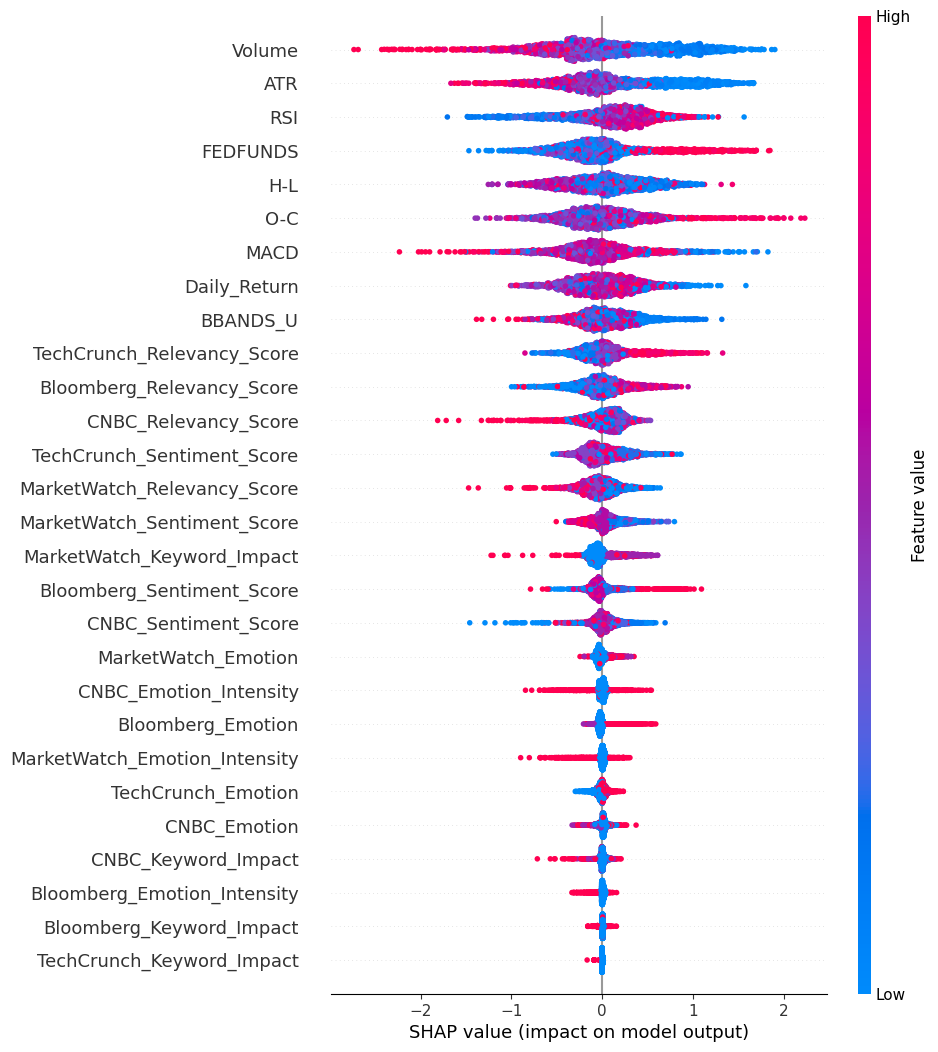

In [183]:
shap.plots.beeswarm(shap_values, max_display=30)

The plot above ranks feature importances from high to low, as evaluated using XGBoost.  

Each dot represents a single day's data entry, with its horizontal position indicating whether the feature’s value pushes the prediction toward 1 (right) or 0 (left). For exampple: 
- A red dot for `BBANDS_U` on the left suggests that a higher lower Bollinger Band value contributes to a prediction of 0.
- A blue dot for `Daily_Return` on the right indicates that a lower recent return pushes the prediction toward 1.

One the other hand, we can directly have the absolute mean of SHAP values for each features. This will give us a more intuitive feeling of their impacts, regardless of positive or negative, to the prediction.

In [184]:
shap_values.shape

(2564, 28)

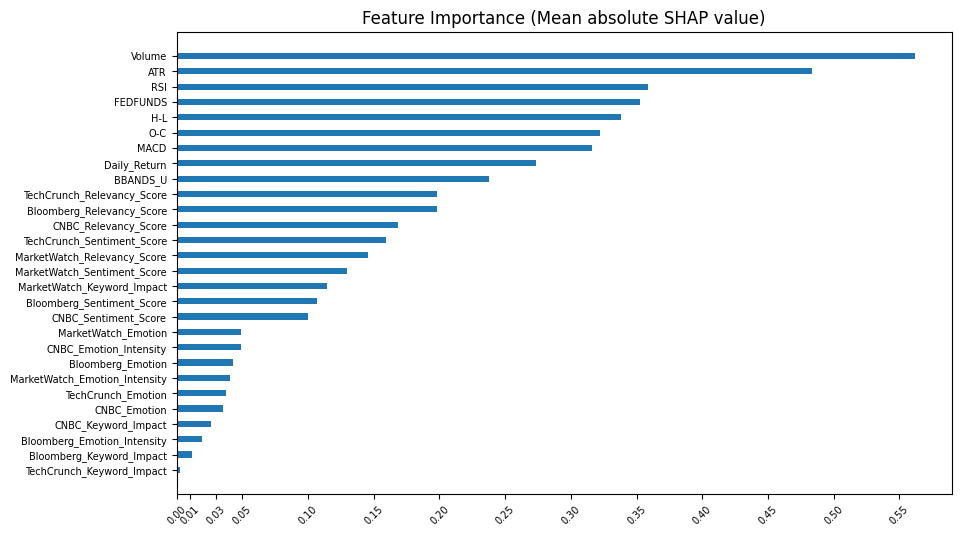

In [185]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(df_qqq_feature_temp.columns[sorted_idx], mean_abs_shap[sorted_idx], height=0.4)
x_ticks = [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
plt.xticks(x_ticks, fontsize=7, rotation=45) 
plt.yticks(fontsize=7)
plt.xticks(x_ticks)
plt.title("Feature Importance (Mean absolute SHAP value)", fontsize=12,)
plt.gca().invert_yaxis()
plt.show()

As shown above, the mean absolute SHAP values range from above 0.01 to approximately 0.55.

Examining the features with the lowest mean absolute SHAP values with consideration of the plot of impact on model output:
- `TechCrunch_Keyword_Impact` has the lowest value — even significantly lower than the usual threshold $0.01$, making it a strong candidate for removal.
- `Bloomberg_Keyword_Impact` and `Bloomberg_Emotion_Intensity` rank as the second and third lowest, exhibiting impact patterns similar to `CNBC_Emotion_Intensity` and `MarketWatch_Emotion_Intensity` respectively, suggesting they may need to be removed.
- `CNBC_Keyword_Impact`, the fourth lowest, behaves somehow also similarly to `MarketWatch_Emotion_Intensity`. It could be removed as well.
- Next one, `CNBC_Emotion` looks slightly unique and its mean absolute SHAP value is already well above 0.03, so I will take a stop here.

While further feature evaluation is possible, I will adopt a conservative approach and limit removals to 4 features at this stage, setting $0.03$ as a reasonable cutoff threshold. This decision is subjective, aimed at maintaining a balanced refinement process.

In [186]:
list_feature_selected_w_filter_wrapper_embedded = df_qqq_feature_temp.columns[np.abs(shap_values.values).mean(0) > 0.03]
print(len(list_feature_selected_w_filter_wrapper_embedded))
print(list_feature_selected_w_filter_wrapper_embedded)

24
Index(['Volume', 'Daily_Return', 'ATR', 'BBANDS_U', 'RSI', 'MACD', 'H-L',
       'O-C', 'FEDFUNDS', 'Bloomberg_Relevancy_Score',
       'Bloomberg_Sentiment_Score', 'Bloomberg_Emotion',
       'CNBC_Relevancy_Score', 'CNBC_Sentiment_Score', 'CNBC_Emotion',
       'CNBC_Emotion_Intensity', 'MarketWatch_Relevancy_Score',
       'MarketWatch_Sentiment_Score', 'MarketWatch_Emotion',
       'MarketWatch_Emotion_Intensity', 'MarketWatch_Keyword_Impact',
       'TechCrunch_Relevancy_Score', 'TechCrunch_Sentiment_Score',
       'TechCrunch_Emotion'],
      dtype='object')


Eliminating the 4 features identified using SHAP concludes the feature selection process. 

**After applying all selection methods, 24 features have been finalized, listed below:** 

`Volume` `Daily_Return` `ATR` `BBANDS_U` `RSI` `MACD` `H-L` `O-C` `FEDFUNDS`  

`Bloomberg_Relevancy_Score` `Bloomberg_Sentiment_Score` `Bloomberg_Emotion`  

`CNBC_Relevancy_Score` `CNBC_Sentiment_Score` `CNBC_Emotion` `CNBC_Emotion_Intensity`  

`MarketWatch_Relevancy_Score` `MarketWatch_Sentiment_Score` `MarketWatch_Emotion`  
`MarketWatch_Emotion_Intensity` `MarketWatch_Keyword_Impact`  

`TechCrunch_Relevancy_Score` `TechCrunch_Sentiment_Score` `TechCrunch_Emotion`

Meanwhile, I will create an official dataframe 'df_qqq_feature' to conclude the effort of feature selection, and use it in the upcoming model building.

In [187]:
df_qqq_feature = df_qqq[list_feature_selected_w_filter_wrapper_embedded]
df_qqq_feature.shape

(2564, 24)

Below is the code to save the current progress as a checkpoint file, ensuring easy retrieval of the data in the future.

In [188]:
#Export the datarame with selected features.
# df_qqq_feature.to_csv('./checkpoints/df_qqq_feature_20250524.csv')

#To recover the process from here, please import the csv:
# df_qqq_feature = pd.read_csv('./checkpoints/df_qqq_feature_20250524.csv')
# df_qqq_feature.set_index("Date", inplace=True)
# df_qqq_feature.index = pd.to_datetime(df_qqq_feature.index).date

[**Back to Content**](#content)

<a id = "C"></a>
# C. Model Building, Tuning and Evaluation  #
Predicting Positive Market Moves Using Gradient Boosting.  
(a) Build a model to predict positive market moves (uptrend) using the feature subset derived above.  
(b) Tune the hyperparameters of the estimator to obtain an optimal model.  
(c) Evaluate the model's prediction quality using the area under the receiver operating characteristic(ROC) curve, confusion matrix, and classification report.

## Answer: ##
In this section, I will use 3 common Gradien Boosting algorithms: **XGBoost, AdaBoost and LightGBM**, to build models and compare their performance based on the evaluation.  
Before getting started, I will need to prepare the train and testing datasets.

Setup features and target.

In [189]:
X = df_qqq_feature.copy()
y = df_qqq['Target']

Split the datasets into training and testing data.

In [190]:
X_train, X_test, y_train, y_test = train_test_split(df_qqq_feature, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Training and testing datasets have sizes of {len(X_train)} and {len(X_test)} respectively.")

Training and testing datasets have sizes of 2051 and 513 respectively.


Normalize features with StandardScaler.

In [191]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define the class weight function. This is designed to handle imbalanced classification, ensuring that underrepresented classes in QQQ ETF prediction receive appropriate weighting during model training.

In [192]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(df_qqq))/2 
    w1=(1/c1)*(len(df_qqq))/2 
    return {0: w0, 1: w1}

The preparation work is done. Now we have X_train_scaled, y_train and X_test_scaled, y_test. Let's get started.

[**Back to Content**](#content)

<a id = "C1"></a>
## C1. XGBoost ##

<a id = "C11"></a>
### C1.1 Build A Model (XGBoost) ###

Adjust the weights and convert the data into DMatrix which is a specialized data structure in XGBoost. We will use dtrain and dtest for our later work with XGBoost.

In [193]:
# Use DMatrix from XGBoost
train_weights = [cwts(y_train)[0] if label == 0 else cwts(y_train)[1] for label in y_train]
dtrain_xgb = xgb.DMatrix(X_train_scaled, label=y_train, 
                         nthread=4,
                         weight=train_weights,
                         feature_names=X_train.columns.to_list())

test_weights = [cwts(y_test)[0] if label == 0 else cwts(y_test)[1] for label in y_test]
dtest_xgb = xgb.DMatrix(X_test_scaled,
                        label=y_test,
                        nthread=4,
                        weight=test_weights,
                        feature_names=X_test.columns.to_list())

In [194]:
print(dtrain_xgb.get_label())  # Check if labels are properly assigned
print(dtrain_xgb.num_row(), dtrain_xgb.num_col())  # Ensure data isn't empty

[0. 1. 1. ... 1. 1. 1.]
2051 24


Next, let's build a base model with some regular parameters as default setting.

In [195]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta':0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'min_child_weight': 1,
    'gamma': 0
}

# train the model
model_xgb_base = xgb.train(
    params, 
    dtrain_xgb, 
    num_boost_round=100,
    evals=[(dtrain_xgb, 'train'), (dtest_xgb, 'eval')],
    early_stopping_rounds=30,
    verbose_eval=False
    )

Then, use the base model to do a prediction with the test data.

In [196]:
# get probabilities 
y_proba_xgb_base = model_xgb_base.predict(dtest_xgb)
# get predictions
y_pred_xgb_base = np.round(y_proba_xgb_base)

**Result - ROC AUC, confusion matrix, classification report, and training test accuracy (XGBoost Base Model)**

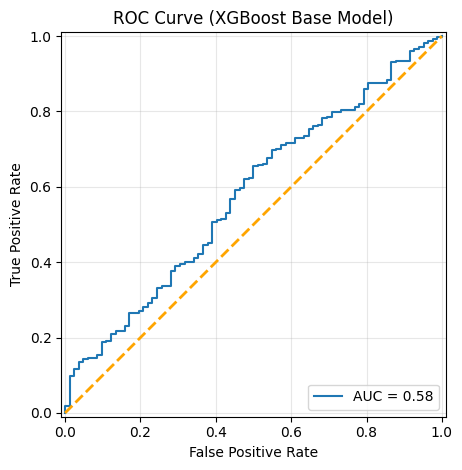

In [197]:
# ROC Curve - XGBoost Base Model
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb_base)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (XGBoost Base Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

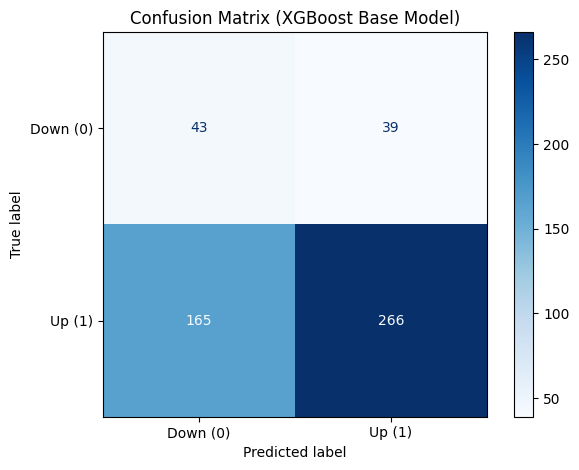

In [198]:
# Confusion Matrix - XGBoost Base Model
cm = confusion_matrix(y_test, y_pred_xgb_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (XGBoost Base Model)')
plt.tight_layout()
plt.show()

In [199]:
# Classification report - XGBoost Base Model
print(f"\n Classification Report (XGBoost Base Model):")
print(classification_report(y_test, y_pred_xgb_base))


 Classification Report (XGBoost Base Model):
              precision    recall  f1-score   support

           0       0.21      0.52      0.30        82
           1       0.87      0.62      0.72       431

    accuracy                           0.60       513
   macro avg       0.54      0.57      0.51       513
weighted avg       0.77      0.60      0.65       513



In [200]:
# Calculate training accuracy - XGBoost Base Model
train_preds_xgb_base = np.round(model_xgb_base.predict(dtrain_xgb))
train_accuracy_xgb_base = accuracy_score(y_train, train_preds_xgb_base)

# Calculate test accuracy
test_preds_xgb_base = np.round(model_xgb_base.predict(dtest_xgb))
test_accuracy_xgb_base = accuracy_score(y_test, test_preds_xgb_base)

print(f"Training Accuracy (XGBoost Base Model): {train_accuracy_xgb_base:.4f}")
print(f"Test Accuracy (XGBoost Base Model): {test_accuracy_xgb_base:.4f}")
print(f"Training Test Difference (XGBoost Base Model): {train_accuracy_xgb_base - test_accuracy_xgb_base:.4f}")

Training Accuracy (XGBoost Base Model): 0.7260
Test Accuracy (XGBoost Base Model): 0.6023
Training Test Difference (XGBoost Base Model): 0.1236


**Result review (XGBoost Base Model)**

Using some regular parameters, we established our initial XGBoost model for this project.

- The AUC value of 0.58 suggests limited predictive separation, meaning the model struggles to distinguish between classes effectively.

- Class 1 (positive market moves) demonstrates strong precision (0.87), confirming reliable predictions.

- Class 0 (negative market moves) has significantly lower precision (0.21), indicating a need for improvement in identifying negative trends.

- The training accuracy (0.7260) exceeds the test accuracy (0.6023) by more than 0.1, signaling over-fitting, as the model performs well on training data but loses accuracy on unseen data.

In summary, while this base model provides some insights, it remains far from optimal. To enhance performance, we will proceed with fine-tuning key parameters.

[**Back to Content**](#content)

<a id = "C12"></a>
### C1.2 Tune the Hyperparameters (XGBoost) ###

Hyperparameters are external model parameters that are not learned directly during training. Instead, they are specified when initializing the classifier. Any parameter defined at the estimator’s construction can be fine-tuned in this manner to improve model performance.

Below are the hyperparameters we are going to explore and fine-tune:
- `max_depth`: maximum depth of a tree, range: $[0,∞)$
- `eta/learning rate`: step size shrinkage used in update to prevents overfitting, range: $[0,1]$
- `subsample`: ratio of the training instances, range: $(0,1]$
- `colsample_bytree`: percentage of features used per tree. High value can lead to overfitting, range: $(0,1]$
- `min_child_weight`: minimum sum of instance weight needed in a child, range: $[0,∞)$
- `gamma`: minimum loss reduction required to make a further partition on a leaf node of the tree, range: $[0,∞)$

**Methods of fine-tuning**  
I explored several methods to deliver the fine-tuning work:

| Methods            | Pros                                                     | Cons                                                        |
|--------------------|---------------------------------------------------------|-------------------------------------------------------------|
| **RandomizedSearchCV** | - Moderately acceptable speed  <br> - Cross-validation prevents overfitting | - Does not cover all combinations |
| **GridSearchCV**     | - Exhaustively searches all hyperparameter combinations  <br> - Cross-validation prevents overfitting | - Computationally expensive |
| **Customized Loop**   | - Flexible—can be designed to meet specific demands  <br> - Faster since validation is not included | - Requires manual input for multiple parameters  <br>  - Must manually check overfitting after results are out |



While **RandomizedSearchCV** and **GridSearchCV** are valuable tools for hyperparameter tuning, I encountered some challenges using them.  

RandomizedSearchCV does **not** test all possible parameter combinations, and there were situations when I mannualy tried out a better combination. Also, since it selects combinations randomly, the results can sometimes be unstable.  

GridSearchCV works well for a small number of combinations, but testing 6 parameters with 3-5 options each makes the process **very slow**. While breaking down the parameter space into smaller search chunks was an option, I opted to write custom loop-based tuning instead.

I implemented a **simple for-loop** to explore all 6 parameters with 3-5 possible values each:  

- `max_depth`, `eta`, and `subsample` are iterated through predefined lists.  
- `colsample_bytree`, `min_child_weight`, and `gamma` are manually adjusted to balance speed and flexibility.  
- The manually adjusted parameters typically require less variation than the looped ones.  
- The loop selects the best AUC value across all tested combinations without cross-validation.  
- However, to mitigate overfitting risks, I will manually review results to ensure no over-fitting.

Below is the customized code for fine-tuning:

In [201]:
best_auc = 0
best_params = None

for max_depth in [3, 4, 5]: #list to loop max_depth
    for eta in [0.01, 0.03, 0.05, 0.1, 0.12]: #list to loop eta
        for subsample in [0.6, 0.7, 0.8, 0.9]: #list to loop subsample
            
            params = {
                'objective': 'binary:logistic', #fixed parameter
                'eval_metric': 'auc', #fixed parameter
                'max_depth': max_depth,
                'eta': eta,
                'subsample': subsample,
                'colsample_bytree': 0.65, #manually change colsample_bytree. I usually try 0.6-0.8
                'min_child_weight': 1, #manually change min_child_weight. I usually try 1, 2, occassionally 3
                'gamma': 0 #manually change gamma. I usually try 0, 0.1, occassionally 0.2
            }
            
            model = xgb.train( #buils a model to test all the combinations
                params,
                dtrain_xgb,
                num_boost_round=100, #fixed parameter
                evals=[(dtrain_xgb, 'train'), (dtest_xgb, 'eval')],
                early_stopping_rounds=30, #fixed parameter
                verbose_eval=False
            )

            y_proba = model.predict(dtest_xgb) #use the model to predict with test set
            y_pred = np.round(y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = auc(fpr, tpr)
            
            if auc_score > best_auc: #save the combination with best AUC
                best_auc = auc_score
                best_params = params

print("Best AUC:", best_auc) #output result
print("Best Parameters:", best_params) #output result

Best AUC: 0.6698545639748741
Best Parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 4, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.65, 'min_child_weight': 1, 'gamma': 0}


[**Back to Content**](#content)

<a id = "C13"></a>
### C1.3 Evaluate the Optimized Model's Prediction Quality (XGBoost) ###

As shown above, after fine-tuning, we have the optimized parameter combination:
- `max_depth`: $4$
- `eta/learning rate`: $0.1$ 
- `subsample`: $0.7$
- `colsample_bytree`: $0.65$
- `min_child_weight`: $1$
- `gamma`: $0$

We are going to test them now.

In [202]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,
    'eta':0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.65,
    'min_child_weight': 1,
    'gamma': 0
}

# train the model
model_xgb_optimized = xgb.train(
    params, 
    dtrain_xgb, 
    num_boost_round=100,
    evals=[(dtrain_xgb, 'train'), (dtest_xgb, 'eval')],
    early_stopping_rounds=30,
    verbose_eval=False
    )

In [203]:
# get probabilities 
y_proba_xgb_optimized = model_xgb_optimized.predict(dtest_xgb)
# get predictions
y_pred_xgb_optimized = np.round(y_proba_xgb_optimized)

**Result - ROC AUC, confusion matrix, classification report, training test accuracy, and feature importance (XGBoost Optimized Model)**

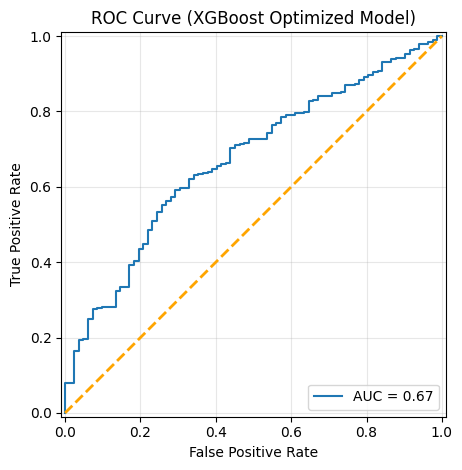

In [204]:
# ROC Curve - XGBoost Optimized Model
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb_optimized)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (XGBoost Optimized Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

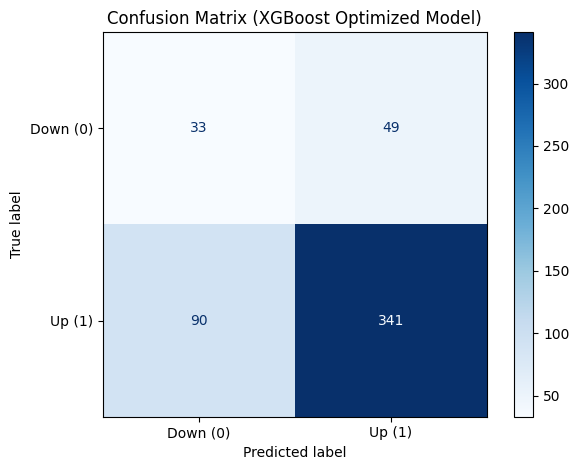

In [205]:
# Confusion Matrix - XGBoost Optimized Model
cm = confusion_matrix(y_test, y_pred_xgb_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (XGBoost Optimized Model)')
plt.tight_layout()
plt.show()

In [206]:
# Classification report - XGBoost Optimized Model
print(f"\n Classification Report (XGBoost Optimized Model):")
print(classification_report(y_test, y_pred_xgb_optimized))


 Classification Report (XGBoost Optimized Model):
              precision    recall  f1-score   support

           0       0.27      0.40      0.32        82
           1       0.87      0.79      0.83       431

    accuracy                           0.73       513
   macro avg       0.57      0.60      0.58       513
weighted avg       0.78      0.73      0.75       513



In [207]:
# Calculate training accuracy - XGBoost Optimized Model
train_preds_xgb_optimized = np.round(model_xgb_optimized.predict(dtrain_xgb))
train_accuracy_xgb_optimized = accuracy_score(y_train, train_preds_xgb_optimized)

# Calculate test accuracy
test_preds_xgb_optimized = np.round(model_xgb_optimized.predict(dtest_xgb))
test_accuracy_xgb_optimized = accuracy_score(y_test, test_preds_xgb_optimized)

print(f"Training Accuracy (XGBoost Optimized Model): {train_accuracy_xgb_optimized:.4f}")
print(f"Test Accuracy (XGBoost Optimized Model): {test_accuracy_xgb_optimized:.4f}")
print(f"Training Test Difference (XGBoost Optimized Model): {train_accuracy_xgb_optimized - test_accuracy_xgb_optimized:.4f}")

Training Accuracy (XGBoost Optimized Model): 0.7840
Test Accuracy (XGBoost Optimized Model): 0.7290
Training Test Difference (XGBoost Optimized Model): 0.0550


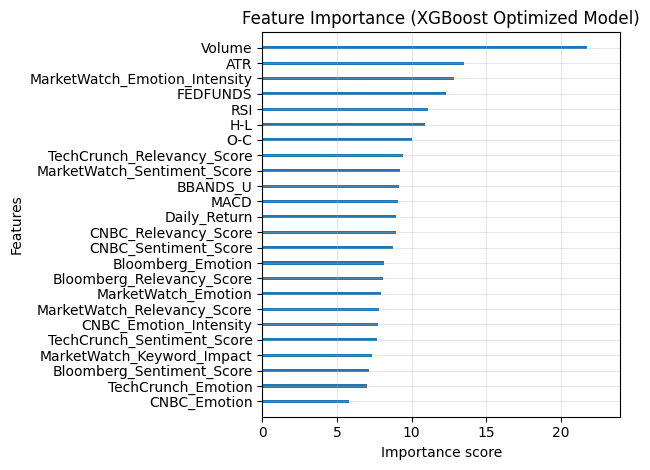

In [208]:
# Plot the feature importance of XGBoost Optimized Model
plot_importance(model_xgb_optimized, importance_type='gain', title='Feature Importance (XGBoost Optimized Model)', show_values=False)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

**Result review (XGBoost Optimized Model)**

With the fine-tuned parameters, we established the optimized XGBoost model for this project.

- AUC improved to 0.67 (previously 0.58), enhancing the model’s ability to separate positive and negative movements more effectively.

- Class 1 (positive market moves) maintains high precision (0.87), while recall has increased to 0.79 (previously 0.62), demonstrating an improved ability to detect positive movements without missing too many instances.

- Class 0 (negative market moves) sees a precision boost to 0.27 (previously 0.21), though it's still not ideal.

- Training accuracy (0.7840) vs. test accuracy (0.7290) shows a difference of 0.0550, indicating better generalization and reduced overfitting compared to the initial version.

- The top influential features span multiple sources: trading data(Volume, ATR), news sentiment (MarketWatch_Emotion_Intensity), and  macro emonomy indicator (FEDFUNDS). This diverse feature set confirms effective feature selection.

In summary, this fine-tuning process has meaningfully improved the model, making it more practical for predictive use.

[**Back to Content**](#content)

<a id = "C2"></a>
## C2. AdaBoost ##

<a id = "C21"></a>
### C2.1 Build A Model (AdaBoost) ###

Adjust weights of training samples for better performance of AdaBoost. No need to prepare special data structure for this algorithm.

In [209]:
# Assign weights to training samples
weights_dict = cwts(y_train)
train_weights = np.array([weights_dict[label] for label in y_train])

Next, let's build a base model with some regular parameters as default setting. We wil use Decision Tree as the base estimator for AdaBoost here.

In [210]:
base_estimator = DecisionTreeClassifier(max_depth=4) 
model_ada_base = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

model_ada_base.fit(X_train_scaled, y_train, sample_weight=train_weights)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.1, n_estimators=100, random_state=42)

Then, use the base model to do a prediction with the test data.

In [211]:
# get probabilities 
y_proba_ada_base = model_ada_base.predict_proba(X_test_scaled)[:, 1]
# get predictions
y_pred_ada_base = np.round(y_proba_ada_base)

**Result - ROC AUC, confusion matrix, classification report, and training test accuracy (AdaBoost Base Model)**

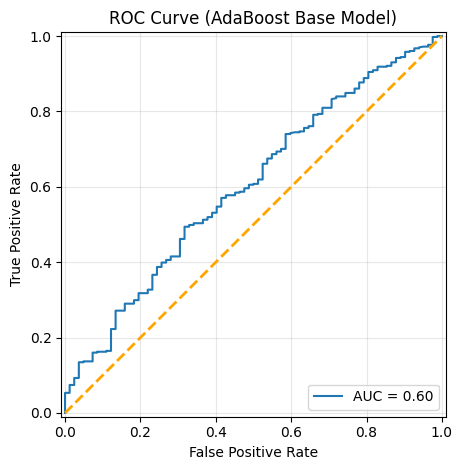

In [212]:
# ROC Curve - AdaBoost Base Model
fpr, tpr, _ = roc_curve(y_test, y_proba_ada_base)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (AdaBoost Base Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

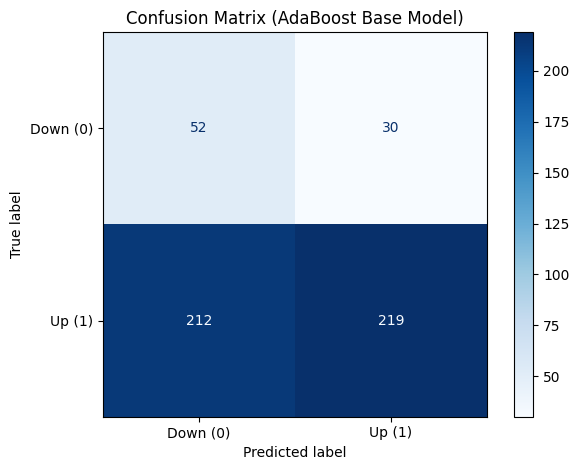

In [213]:
# Confusion Matrix - AdaBoost Base Model
cm = confusion_matrix(y_test, y_pred_ada_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (AdaBoost Base Model)')
plt.tight_layout()
plt.show()

In [214]:
# Classification report - AdaBoost Base Model
print(f"\n Classification Report (AdaBoost Base Model):")
print(classification_report(y_test, y_pred_ada_base))


 Classification Report (AdaBoost Base Model):
              precision    recall  f1-score   support

           0       0.20      0.63      0.30        82
           1       0.88      0.51      0.64       431

    accuracy                           0.53       513
   macro avg       0.54      0.57      0.47       513
weighted avg       0.77      0.53      0.59       513



In [215]:
# Calculate training accuracy - AdaBoost Base Model
train_preds_ada_base = np.round(model_ada_base.predict(X_train_scaled))
train_accuracy_ada_base = accuracy_score(y_train, train_preds_ada_base)

# Calculate test accuracy
test_preds_ada_base = np.round(model_ada_base.predict(X_test_scaled))
test_accuracy_ada_base = accuracy_score(y_test, test_preds_ada_base)

print(f"Training Accuracy (AdaBoost Base Model): {train_accuracy_ada_base:.4f}")
print(f"Test Accuracy (AdaBoost Base Model): {test_accuracy_ada_base:.4f}")
print(f"Training Test Difference (AdaBoost Base Model): {train_accuracy_ada_base - test_accuracy_ada_base:.4f}")

Training Accuracy (AdaBoost Base Model): 0.7138
Test Accuracy (AdaBoost Base Model): 0.5283
Training Test Difference (AdaBoost Base Model): 0.1855


**Result review (AdaBoost Base Model)**

Using some regular parameters, we established our initial AdaBoost model for this project.

- The AUC value of 0.60 suggests the model has moderate challenge to differentiate between positive and negative movements effectively.

- While the precision for class 1 (positive market moves) is strong at 0.88, recall (0.51) means the model misses nearly half of positive moves.

- The precision for class 0 (negative market moves) remains low at 0.20, meaning many false positives for negative moves..

- The gap training accuracy (0.7138) and the test accuracy (0.5283) is almost 0.2, away above 0.1, showing significant over-fitting and making generalization weak on unseen data.

In summary, while this base model offers some insights, it is still not good enough. To enhance performance, we will proceed with fine-tuning key parameters.

[**Back to Content**](#content)

<a id = "C22"></a>
### C2.2 Tune the Hyperparameters (AdaBoost) ###

AdaBoost has fewer tunable parameters compared to XGBoost. Here are some key ones we will explore with a customized loop:
- `max_depth`: parameter of the Decision Tree as the base estimator, it is the maximum depth of a tree, range: $[0,∞)$
- `learning rate`: weight applied to each classifier at each boosting iteration, range: $(0,∞)$
- `n_estimator`: the maximum number of estimators at which boosting is terminated, range: $[1,∞)$

Below is the fine-tuning code:

In [217]:
best_auc = 0
best_params = {}

for max_depth in [3, 4, 5]: #list to loop max_depth
    for learning_rate in [0.01, 0.05, 0.1, 0.15, 0.2]: #list to loop learning_rate
        for n_estimator in [100, 200, 300, 400]: #list to loop n_estimator
            
            base_estimator = DecisionTreeClassifier(max_depth=max_depth)
            
            model = AdaBoostClassifier( #buils a model to test all the combinations
                estimator=base_estimator,
                n_estimators=n_estimator,
                learning_rate=learning_rate,
                random_state=42 #fixed parameter
            )

            model.fit(X_train_scaled, y_train, sample_weight=train_weights)
           
            y_proba = model.predict_proba(X_test_scaled)[:, 1] #use the model to predict with test set
            y_pred = np.round(y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = auc(fpr, tpr)
            
            if auc_score > best_auc: #save the combination with best AUC
                best_auc = auc_score
                best_params['max_depth'] = max_depth
                best_params['learning_rate'] = learning_rate
                best_params['n_estimator'] = n_estimator

print("Best AUC:", best_auc) #output result
print("Best Parameters:", best_params) #output result

Best AUC: 0.6236064738837643
Best Parameters: {'max_depth': 4, 'learning_rate': 0.2, 'n_estimator': 200}


[**Back to Content**](#content)

<a id = "C23"></a>
### C2.3 Evaluate the Optimized Model's Prediction Quality (AdaBoost) ###

As shown above, after fine-tuning, we have the optimized parameter combination:
- `max_depth`: $4$
- `learning rate`: $0.2$ 
- `n_estimator`: $200$

We are going to test them now.

In [218]:
base_estimator = DecisionTreeClassifier(max_depth=4) 
model_ada_optimized = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=0.2,
    random_state=42
)

model_ada_optimized.fit(X_train_scaled, y_train, sample_weight=train_weights)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.2, n_estimators=200, random_state=42)

In [219]:
# get probabilities 
y_proba_ada_optimized = model_ada_optimized.predict_proba(X_test_scaled)[:, 1]
# get predictions
y_pred_ada_optimized = np.round(y_proba_ada_optimized)

**Result - ROC AUC, confusion matrix, classification report, training test accuracy, and feature importance (AdaBoost Optimized Model)**

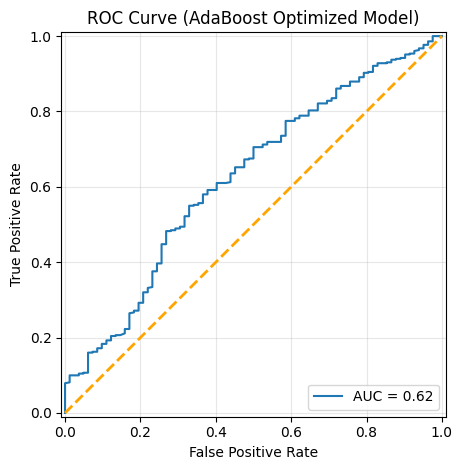

In [220]:
# ROC Curve - AdaBoost Optimized Model
fpr, tpr, _ = roc_curve(y_test, y_proba_ada_optimized)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (AdaBoost Optimized Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

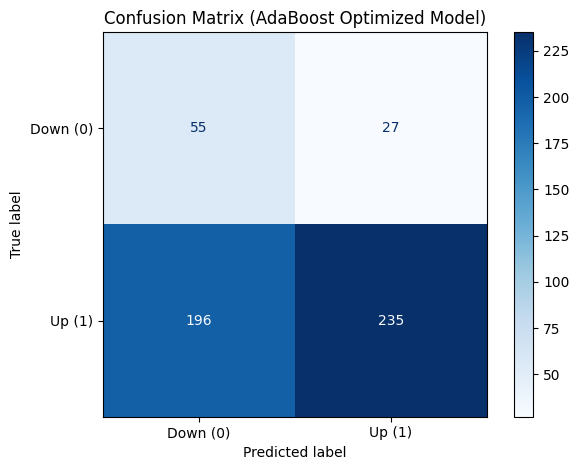

In [221]:
# Confusion Matrix - AdaBoost Optimized Model
cm = confusion_matrix(y_test, y_pred_ada_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (AdaBoost Optimized Model)')
plt.tight_layout()
plt.show()

In [222]:
# Classification report - XGBoost Optimized Model
print(f"\n Classification Report (AdaBoost Optimized Model):")
print(classification_report(y_test, y_pred_ada_optimized))


 Classification Report (AdaBoost Optimized Model):
              precision    recall  f1-score   support

           0       0.22      0.67      0.33        82
           1       0.90      0.55      0.68       431

    accuracy                           0.57       513
   macro avg       0.56      0.61      0.50       513
weighted avg       0.79      0.57      0.62       513



In [223]:
# Calculate training accuracy - AdaBoost Optimized Model
train_preds_ada_optimized = np.round(model_ada_optimized.predict(X_train_scaled))
train_accuracy_ada_optimized = accuracy_score(y_train, train_preds_ada_optimized)

# Calculate test accuracy
test_preds_ada_optimized = np.round(model_ada_optimized.predict(X_test_scaled))
test_accuracy_ada_optimized = accuracy_score(y_test, test_preds_ada_optimized)

print(f"Training Accuracy (AdaBoost Optimized Model): {train_accuracy_ada_optimized:.4f}")
print(f"Test Accuracy (AdaBoost Optimized Model): {test_accuracy_ada_optimized:.4f}")
print(f"Training Test Difference (AdaBoost Optimized Model): {train_accuracy_ada_optimized - test_accuracy_ada_optimized:.4f}")

Training Accuracy (AdaBoost Optimized Model): 0.7474
Test Accuracy (AdaBoost Optimized Model): 0.5653
Training Test Difference (AdaBoost Optimized Model): 0.1821


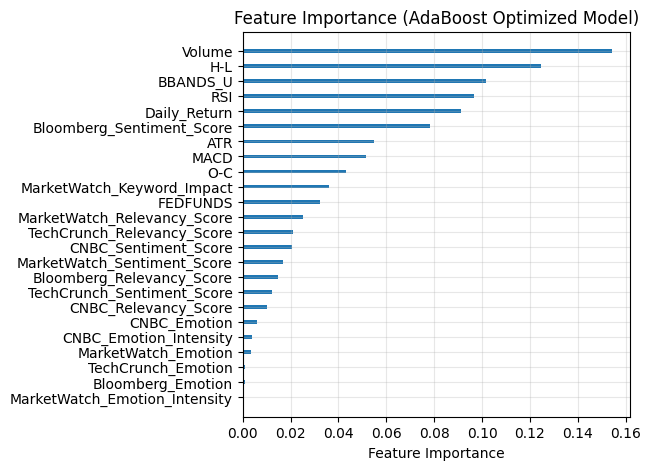

In [226]:
# Extract feature importance from AdaBoost
importances = model_ada_optimized.feature_importances_
feature_names = X_train.columns.to_list()

# Sort importance values for better visualization
sorted_idx = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(5, 5)) 
plt.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx], height = 0.25)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (AdaBoost Optimized Model)")
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Invert to show most important at top
plt.show()

**Result review (AdaBoost Optimized Model)**

With the fine-tuned parameters, we established the optimized AdaBoost model for this project.

- AUC is improved to 0.62 (previously 0.60), showing a slight enhancement in predictive separation.

- Class 1 (positive market moves) shows slightly improved precision (0.90) compared to 0.88, while recall has increased to 0.55 (previously 0.51), indicating better detection of positive movements.

- Class 0 (negative market moves) continues to struggle with low precision (0.22), though recall (0.67) has improved from 0.63, allowing the model to identify more negative moves despite imbalanced predictions.

- The gap between training accuracy (0.7474) and test accuracy (0.5567) remains high, indicating persistent overfitting, which overshadows the performance gains.

- The most influential features primarily originate from trading data (Volume, H-L, BBANDS_U), suggesting that the model may not be leveraging diverse feature sources as effectively as the XGBoost optimized model,

In summary, while the fine-tuned AdaBoost model shows moderate improvements, the significant overfitting risk limits its practical usability.

[**Back to Content**](#content)

<a id = "C3"></a>
## C3. LightGBM ##

<a id = "C31"></a>
### C3.1 Build a model (LightGBM) ###

Adjust the weights and convert the data into lgb.Dataset which is a specialized data structure in LightGBM. We will use dtrain and dtest for our later work with LightGBM.

In [227]:
# Use lgb.Dataset from LightGBM
train_weights = np.array([cwts(y_train)[label] for label in y_train])
dtrain_lgb = lgb.Dataset(X_train_scaled, label=y_train, weight=train_weights, feature_name=X_train.columns.to_list())

test_weights = np.array([cwts(y_test)[label] for label in y_test])
dtest_lgb = lgb.Dataset(X_test_scaled, label=y_test, weight=test_weights, feature_name=X_train.columns.to_list())

Next, let's build a base model with some regular parameters as default setting.

In [228]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'min_child_weight': 1,
    'lambda_l1': 0,  # Equivalent to XGBoost's gamma
    'verbose': -1  # Suppress training logs
}

# train the model
model_lgb_base = lgb.train(
    params,
    dtrain_lgb,
    num_boost_round=100,
    valid_sets=[dtrain_lgb, dtest_lgb],
)

Then, use the base model to do a prediction with the test data.

In [229]:
# get probabilities 
y_proba_lgb_base = model_lgb_base.predict(X_test_scaled)
# get predictions
y_pred_lgb_base = np.round(y_proba_lgb_base)

Check the result.

**Result - ROC AUC, confusion matrix, classification report, and training test accuracy (LightGBM Base Model)**

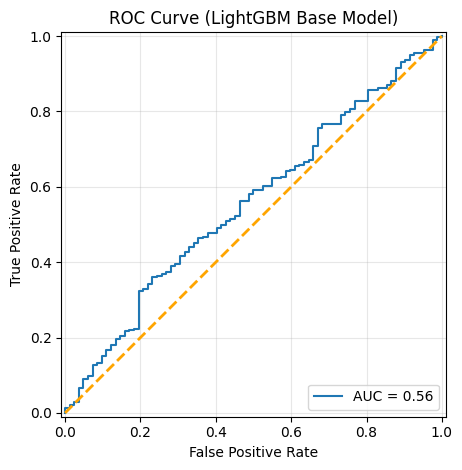

In [230]:
# ROC Curve - LightGBM Base Model
fpr, tpr, _ = roc_curve(y_test, y_proba_lgb_base)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (LightGBM Base Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

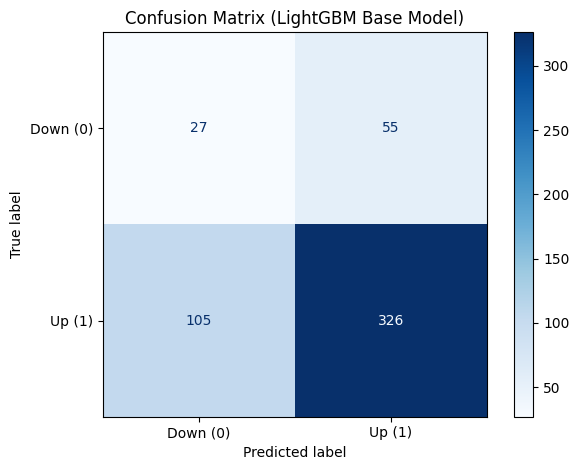

In [231]:
# Confusion Matrix - LightGBM Base Model
cm = confusion_matrix(y_test, y_pred_lgb_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (LightGBM Base Model)')
plt.tight_layout()
plt.show()

In [232]:
# Classification report - LightGBM Base Model
print(f"\n Classification Report (LightGBM Base Model):")
print(classification_report(y_test, y_pred_lgb_base))


 Classification Report (LightGBM Base Model):
              precision    recall  f1-score   support

           0       0.20      0.33      0.25        82
           1       0.86      0.76      0.80       431

    accuracy                           0.69       513
   macro avg       0.53      0.54      0.53       513
weighted avg       0.75      0.69      0.71       513



In [233]:
# Calculate training accuracy - LightGBM Base Model
train_preds_lgb_base = np.round(model_lgb_base.predict(X_train_scaled))
train_accuracy_lgb_base = accuracy_score(y_train, train_preds_lgb_base)

# Calculate test accuracy
test_preds_lgb_base = np.round(model_lgb_base.predict(X_test_scaled))
test_accuracy_lgb_base = accuracy_score(y_test, test_preds_lgb_base)

print(f"Training Accuracy (LightGBM Base Model): {train_accuracy_lgb_base:.4f}")
print(f"Test Accuracy (LightGBM Base Model): {test_accuracy_lgb_base:.4f}")
print(f"Training Test Difference (LightGBM Base Model): {train_accuracy_lgb_base - test_accuracy_lgb_base:.4f}")

Training Accuracy (LightGBM Base Model): 0.8489
Test Accuracy (LightGBM Base Model): 0.6881
Training Test Difference (LightGBM Base Model): 0.1607


**Result review (LightGBM Base Model)**

Using some regular parameters, we established our initial LightGBM model for this project.

- The AUC value of 0.56 suggests quite limited discriminatory power, meaning the model struggles to separate classes effectively.

- Class 1 (positive market moves) demonstrates strong precision (0.86) and decent recall (0.76), effectively capturing a significant portion of positive movements.

- Class 0 (negative market moves) remains challenging, with low precision (0.20) and recall (0.33), indicating a need for improvement in detecting negative trends.

- The training accuracy (0.8489) exceeds the test accuracy (0.6881) by around 0.16, pointing to moderate overfitting, which could reduce performance on unseen data.

In summary, this base model provides a foundation, it is far from optimal. To enhance its performance, we will proceed with fine-tuning key parameters.

[**Back to Content**](#content)

<a id = "C32"></a>
### C3.2 Tune the Hyperparameters (LightGBM) ###

Here are some key parameters of LightGBM we will explore with a customized loop:
- `max_depth`: maximum depth of a tree, range: $[0,∞)$
- `learning_rate`: Step size shrinkage to prevent overfitting by controlling how quickly the model updates weights, range: $[0,1]$
- `subsample`: ratio of the training instances, range: $(0,1]$
- `colsample_bytree`: percentage of features used per tree. High value can lead to overfitting, range: $(0,1]$
- `min_child_weight`: minimum sum of instance weight needed in a child, range: $[0,∞)$

`max_depth`, `learning_rate` and `subsample` will be looped with their respective lists, while `colsample_bytree` and `min_child_weight` will be manually adjusted.  

Below is the fine-tuning code:

In [234]:
best_auc = 0
best_params = None

for max_depth in [3, 4, 5]: #list to loop max_depth
    for learning_rate in [0.01, 0.03, 0.05, 0.1, 0.15]: #list to loop eta
        for subsample in [0.6, 0.7, 0.8, 0.9]: #list to subsample
            params = {
                'objective': 'binary', #fixed parameter
                'metric': 'auc', #fixed parameter
                'max_depth': max_depth,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'colsample_bytree': 0.5, #manually change colsample_bytree. I usually try 0.4-0.7
                'min_child_weight': 1, #manually change min_child_weight. I usually try 1, 2, occassionally 3
            }
            
            model = lgb.train( #buils a model to test all the combination
                params,
                dtrain_lgb,
                num_boost_round=100, #fixed parameter
                valid_sets=[dtrain_lgb, dtest_lgb],
            )

            y_proba = model.predict(X_test_scaled) #use the model to predict with test set
            y_pred = np.round(y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = auc(fpr, tpr)
            
            if auc_score > best_auc: #save the combination with best AUC
                best_auc = auc_score
                best_params = params

print("Best AUC:", best_auc) #output result
print("Best Parameters:", best_params) #output result

Best AUC: 0.5960330484975384
Best Parameters: {'objective': 'binary', 'metric': 'auc', 'max_depth': 3, 'learning_rate': 0.15, 'subsample': 0.6, 'colsample_bytree': 0.5, 'min_child_weight': 1}


[**Back to Content**](#content)

<a id = "C33"></a>
### C3.3 Evaluate the Optimized Model's Prediction Quality (LightGBM) ###

As shown above, after fine-tuning, we have the optimized parameter combination:
- `max_depth`: $3$
- `eta/learning rate`: $0.15$ 
- `subsample`: $0.6$
- `colsample_bytree`: $0.5$
- `min_child_weight`: $1$ 

We are going to test them now.

In [235]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 3,
    'learning_rate': 0.15,
    'subsample': 0.6,
    'colsample_bytree': 0.5,
    'min_child_weight': 1,
}

# Train the model
model_lgb_optimized = lgb.train(
    params,
    dtrain_lgb,
    num_boost_round=100,
    valid_sets=[dtrain_lgb, dtest_lgb],
)

In [236]:
# get probabilities 
y_proba_lgb_optimized = model_lgb_optimized.predict(X_test_scaled)
# get predictions
y_pred_lgb_optimized = np.round(y_proba_lgb_optimized)

**Result - ROC AUC, confusion matrix, classification report, training test accuracy, and feature importance (LightGBM Optimized Model)**

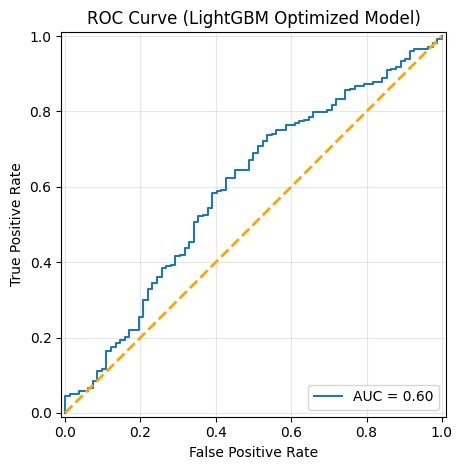

In [237]:
# ROC Curve - LightGBM Optimized Model
fpr, tpr, _ = roc_curve(y_test, y_proba_lgb_optimized)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('ROC Curve (LightGBM Optimized Model)')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

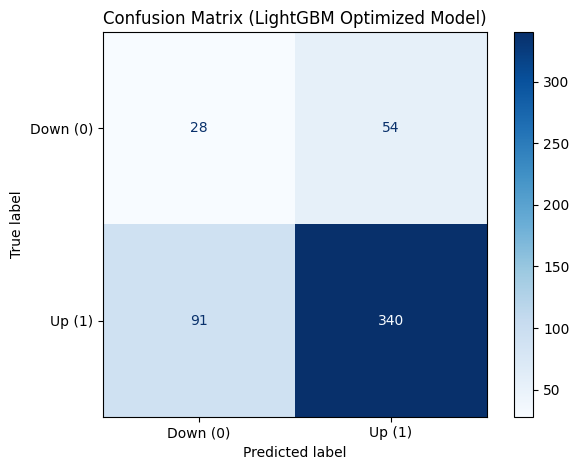

In [238]:
# Confusion Matrix - LightGBM Optimized Model
cm = confusion_matrix(y_test, y_pred_lgb_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (LightGBM Optimized Model)')
plt.tight_layout()
plt.show()

In [239]:
# Classification report - LightGBM Optimized Model
print(f"\n Classification Report (LightGBM Optimized Model):")
print(classification_report(y_test, y_pred_lgb_optimized))


 Classification Report (LightGBM Optimized Model):
              precision    recall  f1-score   support

           0       0.24      0.34      0.28        82
           1       0.86      0.79      0.82       431

    accuracy                           0.72       513
   macro avg       0.55      0.57      0.55       513
weighted avg       0.76      0.72      0.74       513



In [240]:
# Calculate training accuracy - LightGBM Optimized Model
train_preds_lgb_optimized = np.round(model_lgb_optimized.predict(X_train_scaled))
train_accuracy_lgb_optimized = accuracy_score(y_train, train_preds_lgb_optimized)

# Calculate test accuracy
test_preds_lgb_optimized = np.round(model_lgb_optimized.predict(X_test_scaled))
test_accuracy_lgb_optimized = accuracy_score(y_test, test_preds_lgb_optimized)

print(f"Training Accuracy (LightGBM Optimized Model): {train_accuracy_lgb_optimized:.4f}")
print(f"Test Accuracy (LightGBM Optimized Model): {test_accuracy_lgb_optimized:.4f}")
print(f"Training Test Difference (LightGBM Optimized Model): {train_accuracy_lgb_optimized - test_accuracy_lgb_optimized:.4f}")

Training Accuracy (LightGBM Optimized Model): 0.8259
Test Accuracy (LightGBM Optimized Model): 0.7173
Training Test Difference (LightGBM Optimized Model): 0.1086


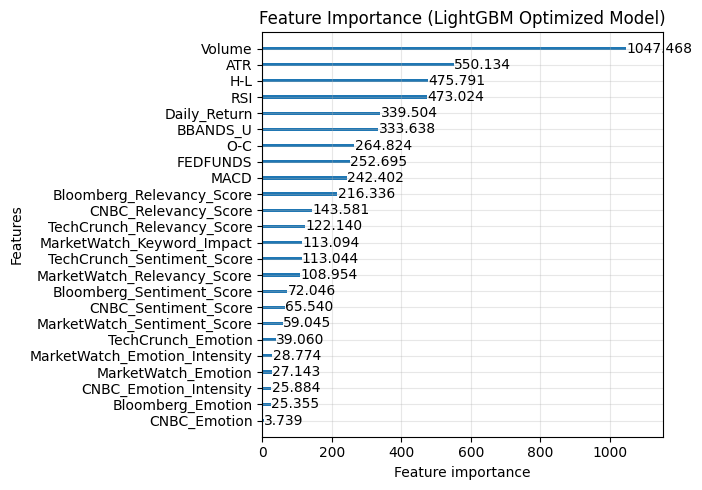

In [246]:
lgb.plot_importance(model_lgb_optimized, importance_type='gain', title='Feature Importance (LightGBM Optimized Model)',figsize=(7, 5))
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

**Result review (LightGBM Optimized Model)**

With the fine-tuned parameters, we established the optimized LightGBM model for this project.

- AUC is improved to 0.60 (previously 0.56), indicating better predictive separation, but still well below the 0.70+ threshold for robust classification.

- Class 1 (positive market moves) maintains strong predictive reliability, with precision at 0.86 and an improved recall of 0.79 (previously 0.76), allowing the model to capture more true positives.

- Class 0 (negative market moves) sees a slight improvement in precision (0.24, up from 0.20) and recall (0.34, up from 0.33), though its performance remains suboptimal.

- Training accuracy (0.8259) vs. test accuracy (0.7173) shows a gap of ~0.11, reducing over-fitting compared to the base model, but not enough to fully mitigate the concern of over-fitting.

- The model’s most influential features primarily come from trading data (Volume, ATR, H-L), similar to the AdaBoost optimized model, suggesting that the model may not be leveraging diverse feature sources as effectively as the XGBoost optimized model.

In summary, while the fine-tuning has improved performance, the model still exhibits weaknesses that limit its practical usability.

[**Back to Content**](#content)

<a id = "C4"></a>
## C4. Conclusion of Models ##

Here is a camparision table of the results from all 3 optimized models:

| Evaluation Metric           | XGBoost    | AdaBoost | LightGBM  |
|-----------------------------|------------|----------|-----------|
| **AUC**                     | **0.67**   | 0.62     | 0.60      |
| **Class 1 Precision**       | 0.87       | **0.90** | 0.86      |
| **Class 1 Recall**          | **0.79**   | 0.55     | **0.79**  |
| **Class 1 F1-score**        | **0.83**   | 0.68     | 0.82      |
| **Class 0 Precision**       | **0.27**   | 0.22     | 0.24      |
| **Class 0 Recall**          | **0.40**   | 0.67     | 0.34      |
| **Class 0 F1-score**        | 0.32       | **0.33** | 0.28      |
| **Training Accuracy**       | 0.7840     | 0.7474   | **0.8259**|
| **Test Accuracy**           | **0.7290** | 0.5653   | 0.7173    |
| **Train-Test Accuracy Gap** | **0.0550** | 0.1821   | 0.1086    |


Among the 3 models, XGBoost emerges as the strongest performer due to several key advantages:
- Highest AUC (0.67), making it the only model approaching the 0.70 threshold, which indicates superior class separation.
- Balanced precision-recall trade-off for both Class 1 and Class 0, ensuring more reliable predictions.
- Highest test accuracy (0.7290) with minimal overfitting (gap of 0.0550), demonstrating strong generalization to unseen data.
- In contrast, AdaBoost and LightGBM performs worse but with higher overfitting, leading to lower overall stability and predictive reliability.

**In conclusion, the XGBoost optimized model proves to be the most consistent and effective choice for QQQ ETF movement prediction.**   
Next, I will integrate it into a trading strategy to evaluate its practical performance in real-world conditions.


[**Back to Content**](#content)

<a id = "T"></a>
# Trading Strategy Practice with Backtesting #

<a id = "T1"></a>
## T1. Profit Analysis ##
To assess the effectiveness of the XGBoost optimized model, we will conduct a simple backtesting exercise using the 10-years QQQ price data. The trading rules are straightforward:
- **Buy Signal (Predicted = 1):** Purchase one share of QQQ ETF at the day's adjusted closing price.
- **Sell on the Next Day:** If a purchase occurs, the position will be sold at the next day's adjusted closing price.
- **No Trade (Predicted = 0):** No transaction is executed on this day related to this predicition.
- **No Transaction Costs or Friction Included:** This backtest assumes a cost-free trading environment for simplicity.

Trades following these rules will be referred to as the **XGBoost Strategy** in the subsequent analysis. Now, let's put it to the test.

First, use the XGBoost optimized model to predict QQQ’s next-day price movements over the past 10 years.  

_*Ensure that the input DMatrix is prepared without using any data from the `Target` column._

In [258]:
# prepare the feature data
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df_qqq_feature)

# use the model to predict
dtest_all_xgb = xgb.DMatrix(X_all_scaled,
                            nthread=4,
                            feature_names=df_qqq_feature.columns.to_list())
# get probabilities 
y_proba_all_xgb_optimized = model_xgb_optimized.predict(dtest_all_xgb)
# get predictions
y_pred_all_xgb_optimized = np.round(y_proba_all_xgb_optimized)

Create a new dataframe 'df_qqq_strategy', only include `Adj Close`, `Daily_Return`, and and the just-now generated `XGBoost_Prediction data`.

In [259]:
df_qqq_strategy = df_qqq[['Adj Close', 'Daily_Return']]
df_qqq_strategy = df_qqq_strategy.copy()
df_qqq_strategy['XGBoost_Prediction'] = y_pred_all_xgb_optimized.astype(int)

To accurately track daily trading activities under the XGBoost Strategy over the past 10 years, create the following columns:
- `Buy_Price`: Records the amount spent to purchase one share of QQQ ETF on a given day, if any.
- `Sell_Price`: Captures the amount received from selling the share bought on the previous day, if any.
- `Profit`: Computes the net earnings from each trade by subtracting the previous day's Buy Price from the current day's Sell Price, representing the money made from this round of transaction.

In [260]:
# Create Buy Price column → Price when 'Predicted' is 1, otherwise 0
df_qqq_strategy['Buy_Price'] = df_qqq_strategy['Adj Close'] * df_qqq_strategy['XGBoost_Prediction']

# Create Sell Price column → Price when 'Predicted' was 1 in the previous row
df_qqq_strategy['Sell_Price'] = df_qqq_strategy['Adj Close'] * df_qqq_strategy['XGBoost_Prediction'].shift(1).fillna(0)

df_qqq_strategy['Profit'] = df_qqq_strategy['Sell_Price'] - df_qqq_strategy['Buy_Price'].shift(1)
df_qqq_strategy['Profit'] = df_qqq_strategy['Profit'].fillna(0)  # Ensure NaN values are set to 0

Meanwhile, to evaluate the strategy’s performance, introduce two additional columns:
- `Cumulative_Profit`: Tracks the total accumulated profit from all executed trades, providing insight into the strategy’s overall profitability.
- `Buy_Hold_Profit`: Represents the profit generated without any trading strategy—either from a simple buy-and-hold approach (holding QQQ until the last day) or daily buying and selling. This serves as a benchmark to assess how the XGBoost strategy compares to a passive investment approach.

In [261]:
df_qqq_strategy['Cumulative_Profit'] = df_qqq_strategy['Profit'].cumsum()
df_qqq_strategy['Buy_Hold_Profit'] = df_qqq_strategy['Adj Close'].diff().fillna(0).cumsum()

In [264]:
df_qqq_strategy.tail()

,Adj Close,Daily_Return,XGBoost_Prediction,Buy_Price,Sell_Price,Profit,Cumulative_Profit,Buy_Hold_Profit
Date,,,,,,,,
2025-05-09,487.970001,-0.000655,1,487.970001,0.000000,0.000000,649.641617,388.429703
2025-05-12,507.850006,0.040740,0,0.000000,507.850006,19.880005,669.521622,408.309708
2025-05-13,515.590027,0.015241,0,0.000000,0.000000,0.000000,669.521622,416.049728
2025-05-14,518.679993,0.005993,0,0.000000,0.000000,0.000000,669.521622,419.139694
2025-05-15,519.250000,0.001099,0,0.000000,0.000000,0.000000,669.521622,419.709702


In [271]:
print(f"Final XGBoost Strategy Profit per Share: ${df_qqq_strategy['Cumulative_Profit'].iloc[-1]:.2f}")
print(f"Final Buy & Hold Profit per Share: ${df_qqq_strategy['Buy_Hold_Profit'].iloc[-1]:.2f}")

Final XGBoost Strategy Profit per Share: $669.52
Final Buy & Hold Profit per Share: $419.71


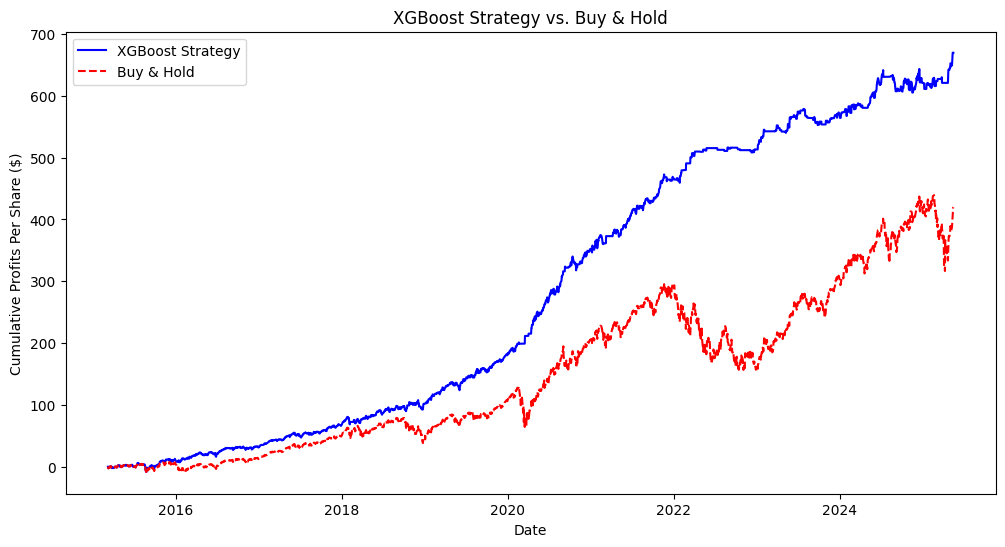

In [272]:
# Plot Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(df_qqq_strategy.index, df_qqq_strategy["Cumulative_Profit"], label="XGBoost Strategy", color="blue")
plt.plot(df_qqq_strategy.index, df_qqq_strategy["Buy_Hold_Profit"], label="Buy & Hold", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Cumulative Profits Per Share ($)")
plt.title("XGBoost Strategy vs. Buy & Hold")
plt.legend()
plt.show()

The results demonstrate that the XGBoost strategy yields a profit of $\$669.52$ per share over the past 10 years, significantly outperforming the buy-and-hold approach, which generates $\$419.71$ per share — a $60\%$  improvement in overall profits!

Additionally, the profit comparison plot highlights the smoother and more consistent growth of the XGBoost strategy. Unlike buy-and-hold, which experiences greater volatility and market downturns, the XGBoost-driven approach effectively navigates market fluctuations, maintaining a steadier and more robust upward trajectory throughout the period.

[**Back to Content**](#content)

<a id = "T2"></a>
## T2. Pyfolio Analysis ##
Pyfolio is a powerful Python library for analyzing portfolio performance and risk management, making it especially valuable for evaluating backtested trading strategies. It provides a comprehensive set of metrics and visualizations to assess a strategy’s effectiveness.

To leverage this automated tool, we need to create a `XGBoost_Return` column, which captures the daily percentage return from trades executed using the XGBoost strategy. This serves as the core dataset for Pyfolio's analysis, enabling a detailed evaluation of the strategy's performance over time.

In [276]:
df_qqq_strategy['XGBoost_Return'] =  df_qqq_strategy['Daily_Return'] * df_qqq_strategy['XGBoost_Prediction'].shift(1).fillna(0)
df_qqq_strategy.tail()

,Adj Close,Daily_Return,XGBoost_Prediction,Buy_Price,Sell_Price,Profit,Cumulative_Profit,Buy_Hold_Profit,XGBoost_Return
Date,,,,,,,,,
2025-05-09,487.970001,-0.000655,1,487.970001,0.000000,0.000000,649.641617,388.429703,-0.00000
2025-05-12,507.850006,0.040740,0,0.000000,507.850006,19.880005,669.521622,408.309708,0.04074
2025-05-13,515.590027,0.015241,0,0.000000,0.000000,0.000000,669.521622,416.049728,0.00000
2025-05-14,518.679993,0.005993,0,0.000000,0.000000,0.000000,669.521622,419.139694,0.00000
2025-05-15,519.250000,0.001099,0,0.000000,0.000000,0.000000,669.521622,419.709702,0.00000


Then we submit the `XGBoost_Return` column to Pyfolio for analysis, reviewing the returns generated by the XGBoost strategy.

To benchmark performance, we also provide Pyfolio with the `Daily Return` column, representing the default returns without a strategy (Buy-and-Hold).

Here are the result tables:

In [277]:
pf.show_perf_stats(df_qqq_strategy["XGBoost_Return"])

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.5%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Start date,2015-03-09
End date,2025-05-15
Total months,122
,Backtest
Annual return,32.5%
Cumulative returns,1657.5%
Annual volatility,13.5%
Sharpe ratio,2.16
Calmar ratio,2.33
Stability,0.97
Max drawdown,-13.9%


Review the Pyfolio result table of the default daily return as benchmark.

In [278]:
pf.show_perf_stats(df_qqq_strategy["Daily_Return"])

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.7%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Start date,2015-03-09
End date,2025-05-15
Total months,122
,Backtest
Annual return,17.7%
Cumulative returns,423.2%
Annual volatility,22.5%
Sharpe ratio,0.84
Calmar ratio,0.50
Stability,0.95
Max drawdown,-35.1%


As shown in the above tables, the XGBoost strategy significantly outperforms the default QQQ buy-and-hold approach across multiple key metrics:
- It delivers a substantially higher annual return (32.5% vs. 17.7%) and greater cumulative returns (1657.5% vs. 423.2%) while maintaining lower volatility (13.5% vs. 22.5%), demonstrating a more stable trading pattern.
- The Sharpe ratio (2.16 vs. 0.84) and Sortino ratio (3.50 vs. 1.19) reinforce its superior risk-adjusted performance, showing that the strategy generates more efficient returns relative to its risk exposure.
- Capital preservation is significantly improved with the strategy, with a shallower maximum drawdown (-13.9% vs. -35.1%), protecting against extreme market downturns. Additionally, a higher Calmar ratio (2.33 vs. 0.50) highlights a stronger balance between return and drawdown risk.
- While the XGBoost model exhibits slightly higher skew (0.46 vs. -0.18) and similar kurtosis, its tail ratio (1.23 vs. 0.92) indicates better resilience to extreme price movements.

#### Overall, the XGBoost strategy proves to be a more profitable, risk-efficient, and stable approach for trading QQQ ETF compared to a simple buy-and-hold method. It not only enhances return potential but also mitigates volatility risks, making it a compelling choice for systematic trading. ####

# My answer is finished, thank you! #

[**Back to Content**](#content)